# IMPORTS
Copied and pasted, have not cleared out the unnecessary bits.

In [1]:
import os, gc, sys, warnings
from glob import glob
import importlib

sys.path.append(r'D:/Storage/Repositories/SeaExplorerTools')
import SXBQ as sx
import BYQtools as byq

# from tqdm.notebook import tqdm
from tqdm import tqdm
from multiprocessing import Pool
from datetime import datetime as dt
    
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import fsolve, fmin
from scipy.signal import convolve as conv

import gsw

import matplotlib.pyplot as plt
import seaborn as sns
import cmocean.cm as cmo

warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action='ignore', message='invalid value encountered in divide')

sns.set(font='Franklin Gothic Book',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'lightgrey',
         'axes.grid': False,
         'axes.labelcolor': 'darkgrey',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'dimgrey',
         'xtick.bottom': False,
         'xtick.color': 'dimgrey',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'dimgrey',
         'ytick.direction': 'out',
         'ytick.left': False,
         'ytick.right': False},
         font_scale=1)

In [2]:
def RunningMedian(x,N):
    grid = np.ones((len(x)+2*N, 1 + 2*N ))*np.NaN
    for istep in range(np.shape(grid)[1]):
        grid[istep:len(x)+istep, istep] = x
    return np.nanmedian(grid,axis=1)[N:-N]

def RunningMax(x,N):
    grid = np.ones((len(x)+2*N, 1 + 2*N ))*np.NaN
    for istep in range(np.shape(grid)[1]):
        grid[istep:len(x)+istep, istep] = x
    return np.nanmax(grid,axis=1)[N:-N]

def RunningMin(x,N):
    grid = np.ones((len(x)+2*N, 1 + 2*N ))*np.NaN
    for istep in range(np.shape(grid)[1]):
        grid[istep:len(x)+istep, istep] = x
    return np.nanmin(grid,axis=1)[N:-N]

def RunningMean(x,N):
    grid = np.ones((len(x)+2*N, 1 + 2*N ))*np.NaN
    for istep in range(np.shape(grid)[1]):
        grid[istep:len(x)+istep, istep] = x
    return np.nanmean(grid,axis=1)[N:-N]

def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)

def rmsd(x):
    return np.sqrt(np.nanmean(x**2))

def plog(msg):
    print(str(dt.now().replace(microsecond=0))+' : '+msg)
    return None

In [3]:
# data = sx.load('Oman_M7.pqt')
# adcp_path = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/220808_Dep7_post/ADCP/sea057_M51.ad2cp.00000*.nc'
# top_mounted = False

# ### Bornholm
# adcp_path = 'D:/Storage/VOTO_ADCP/Bornholm/sea063_M22.ad2cp.00000*.nc'
# data = sx.load('Bornholm_test.pqt')
# top_mounted = True

### Skagerak
adcp_path = 'D:/Storage/VOTO_ADCP/Skag/sea045_M44.ad2cp.00000*.nc'
data = sx.load('Skag_test.pqt')
top_mounted = True

Loaded Skag_test.pqt


# Begin ADCP Data Processing (refactor from here?)

In [4]:
options = {
    'debug' : True,
    'correctADCPHeading' : True,
    'ADCP_discardFirstBins' : 0, # First bin often very affected by glider, good to discard, in future we should extend blanking distance
    'ADCP_correlationThreshold': 70, # 70
    'ADCP_amplitudeThreshold' : 75, # 75
    'ADCP_velocityThreshold' : 0.8, # 0.6
    'correctXshear' : False,
    'correctYshear' : False,
    'correctZshear' : False,
    'correctZZshear' : False,
    }

# correctOxygenLag = False

# depth_weighting for sheaar correction regression

## Load ADCP data

In [5]:
ADCP = xr.open_mfdataset(adcp_path,group='Data/Average')
BT = xr.open_mfdataset(adcp_path,group='Data/AverageBT')
ADCP_settings = xr.open_mfdataset(glob(adcp_path)[0],group='Config')

bin_size = ADCP_settings.attrs['avg_cellSize']
blanking_distance = ADCP_settings.attrs['avg_blankingDistance']

plog('Finished loading ADCP data')

2023-03-22 23:40:26 : Finished loading ADCP data


## Bring in necessary glider variables

In [6]:
# Coordinates
ADCP = ADCP.assign_coords(
    Latitude=("time", 
              interp( data.data['Timestamp'].values.astype('float'), data.data['latitude'], ADCP.time.values.astype('float') ) ))
ADCP = ADCP.assign_coords(
    Longitude=("time", 
              interp( data.data['Timestamp'].values.astype('float'), data.data['latitude'], ADCP.time.values.astype('float') ) ))

# Profile and depth
ADCP = ADCP.assign_coords(
    profileNum=("time", 
                np.round(interp(data.data['Timestamp'].values.astype('float'), data.data['profileNum'], ADCP.time.values.astype('float'))) ))
ADCP = ADCP.assign_coords(
    Depth=("time", -gsw.z_from_p(ADCP['Pressure'].values,ADCP['Latitude'].values)))



# overwrite temperature with glider temperature?
ADCP['salinity'] = ('time', interp(data.data['Timestamp'].values.astype('float'), data.data['salinity'], ADCP.time.values.astype('float')) )
ADCP['declination'] = ('time', interp(data.data['Timestamp'].values.astype('float'), data.data['Declination'], ADCP.time.values.astype('float')) )
ADCP['glider_soundspeed'] =  ('time', interp(data.data['date_float'].values, data.data['soundspeed'], ADCP.time.values.astype('float')) )




# Get rid of pointless dimensions and make them coordinates instead
ADCP = ADCP.assign_coords(
    bin=("Velocity Range", np.arange(len(ADCP['Velocity Range'].values))))
ADCP = ADCP.swap_dims({'Velocity Range':'bin'})

ADCP = ADCP.assign_coords(
    bin=("Correlation Range", np.arange(len(ADCP['Correlation Range'].values))))
ADCP = ADCP.swap_dims({'Correlation Range':'bin'})

ADCP = ADCP.assign_coords(
    bin=("Amplitude Range", np.arange(len(ADCP['Amplitude Range'].values))))
ADCP = ADCP.swap_dims({'Amplitude Range':'bin'})

plog('Added glider variables')

2023-03-22 23:40:27 : Added glider variables


# Start QC Calculate depth of each individual measurement

## Calculate depth of each measurement

2023-03-22 23:40:27 : Depth calculation of cells correct. Beam 1 2 4 match on down; 3 2 4 match on up. (Tested on downward facing)


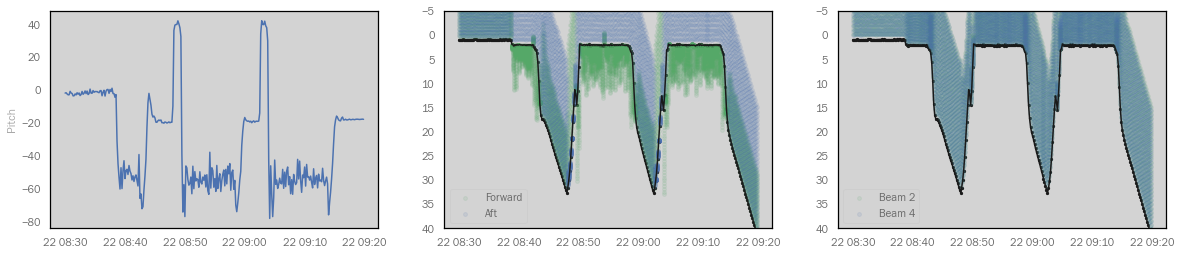

In [7]:
## All *_Range coordinates are distance along beam. Verified with data.

def remapADCPdepth(ADCP, bin_size, blanking_distance, top_mounted=top_mounted):
    if top_mounted:
        direction = 1
        theta_rad_1 = np.arccos(  np.cos(np.deg2rad(47.5 - ADCP['Pitch']))  * np.cos(np.deg2rad(ADCP['Roll']))  )
        theta_rad_2 = np.arccos(  np.cos(np.deg2rad(25 -   ADCP['Roll'] ))  * np.cos(np.deg2rad(ADCP['Pitch']))  )
        theta_rad_3 = np.arccos(  np.cos(np.deg2rad(47.5 + ADCP['Pitch']))  * np.cos(np.deg2rad(ADCP['Roll']))  )
        theta_rad_4 = np.arccos(  np.cos(np.deg2rad(25 +   ADCP['Roll'] ))  * np.cos(np.deg2rad(ADCP['Pitch']))  )
    else:
        direction = -1
        theta_rad_1 = np.arccos(  np.cos(np.deg2rad(47.5 + ADCP['Pitch']))  * np.cos(np.deg2rad(ADCP['Roll']))  )
        theta_rad_2 = np.arccos(  np.cos(np.deg2rad(25 +   ADCP['Roll'] ))  * np.cos(np.deg2rad(ADCP['Pitch']))  )
        theta_rad_3 = np.arccos(  np.cos(np.deg2rad(47.5 - ADCP['Pitch']))  * np.cos(np.deg2rad(ADCP['Roll']))  )
        theta_rad_4 = np.arccos(  np.cos(np.deg2rad(25 -   ADCP['Roll'] ))  * np.cos(np.deg2rad(ADCP['Pitch']))  )
    # Upward facing ADCP, so beam 1 ~= 30 deg on the way up, beam 3 on the way down, when flying at 17.4 degree pitch.
    # Returns angles of each beam from the UP direction
    
    z_bin_distance = ADCP['Velocity Range'].values
    
    ADCP['D1'] = (
                   ['time','bin'],
                   np.tile(ADCP['Depth'], (len(ADCP.bin), 1)).T \
                     - direction \
                     * np.tile(z_bin_distance, (len(ADCP.time), 1)) \
                     * np.tile(np.cos(theta_rad_1), (len(ADCP.bin), 1)).T \
                   )
    ADCP['D2'] = (
                   ['time','bin'],
                   np.tile(ADCP['Depth'], (len(ADCP.bin), 1)).T \
                    - direction \
                    * np.tile(z_bin_distance, (len(ADCP.time), 1)) \
                    * np.tile(np.cos(theta_rad_2), (len(ADCP.bin), 1)).T \
                  )
    ADCP['D3'] = (
                   ['time','bin'],
                   np.tile(ADCP['Depth'], (len(ADCP.bin), 1)).T \
                    - direction \
                    * np.tile(z_bin_distance, (len(ADCP.time), 1)) \
                    * np.tile(np.cos(theta_rad_3), (len(ADCP.bin), 1)).T \
                  )
    ADCP['D4'] = (
                   ['time','bin'],
                   np.tile(ADCP['Depth'], (len(ADCP.bin), 1)).T \
                    - direction \
                    * np.tile(z_bin_distance, (len(ADCP.time), 1)) \
                    * np.tile(np.cos(theta_rad_4), (len(ADCP.bin), 1)).T \
                  )  
    
    if options['debug']:
        plt.close('all')
        plt.figure(figsize=(20,4))
        x = np.arange(300)
        times = np.tile(ADCP.time[x].values, (len(ADCP['bin']), 1)).T

        plt.subplot(131)
        plt.plot(ADCP.time[x],ADCP.Pitch[x])
        plt.ylabel('Pitch')

        plt.subplot(132)
        plt.scatter(ADCP.time[x],ADCP.Pressure[x],5,'k')
        plt.scatter(times.flatten(),ADCP.isel(time=x)['D1'].values.flatten(),15,'g',alpha=0.1, label='Forward')
        plt.scatter(times.flatten(),ADCP.isel(time=x)['D3'].values.flatten(),15,'b',alpha=0.1, label='Aft')
        plt.plot(ADCP.time[x],ADCP.Pressure[x],'k')
        plt.legend()

        plt.ylim([-5,40])
        plt.gca().invert_yaxis()

        plt.subplot(133)
        plt.scatter(ADCP.time[x],ADCP.Pressure[x],5,'k')
        plt.scatter(times.flatten(),ADCP.isel(time=x)['D2'].values.flatten(),15,'g',alpha=0.1, label='Beam 2')
        plt.scatter(times.flatten(),ADCP.isel(time=x)['D4'].values.flatten(),15,'b',alpha=0.1, label='Beam 4')
        plt.plot(ADCP.time[x],ADCP.Pressure[x],'k')
        plt.legend()

        plt.ylim([-5,40])
        plt.gca().invert_yaxis()
    return ADCP

ADCP = remapADCPdepth(ADCP,bin_size,blanking_distance)

plog('Depth calculation of cells correct. Beam 1 2 4 match on down; 3 2 4 match on up. (Tested on downward facing)')

In [8]:
## ADJUST DISTANCE BASED ON SOUNDSPEED !

## Correct ADCP Heading

        <total-intensity units="nT">51039</total-intensity>

Target = 510.39
Optimization terminated successfully.
         Current function value: 2.312568
         Iterations: 956
         Function evaluations: 1359
[[ 8.21005866e-01 -3.83221955e-02 -1.92652097e-02]
 [-5.39439514e-04  8.54898793e-01 -8.35052039e-03]
 [-9.91747987e-03 -5.26418160e-03  8.53100949e-01]]
[ 0.02260588  0.04487561 -0.01074626]
2023-03-22 23:41:03 : Corrected heading and accounted for declination


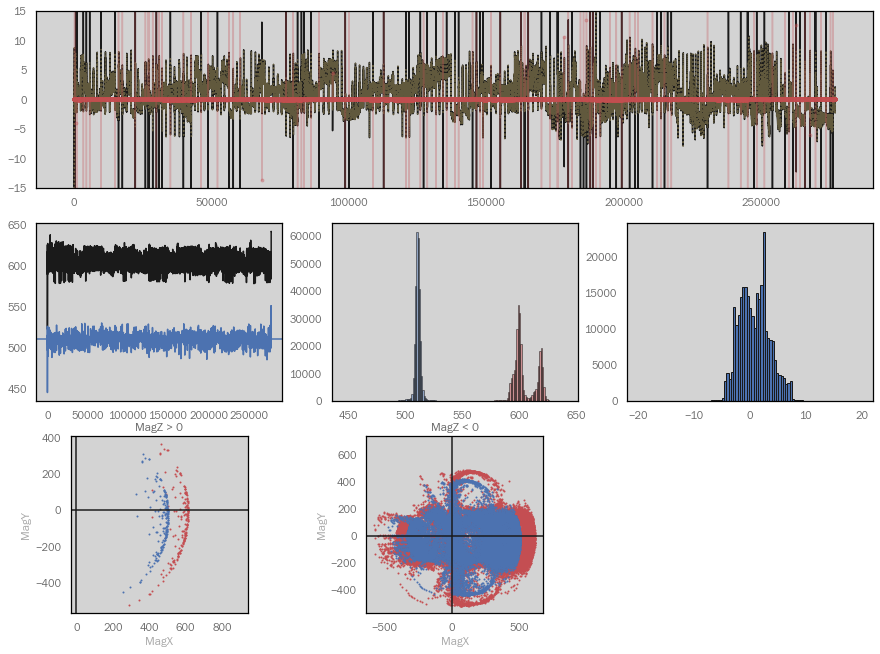

In [9]:
def _process(ADCP):
    # # Get local geomagnetic target strength:
    def getGeoMagStrength():    
        lat = np.nanmedian(data.data.latitude)
        lon = np.nanmedian(data.data.longitude)
        date = pd.to_datetime(np.nanmean(data.data.Timestamp.values.astype('float')))
        year = date.year
        month = date.month
        day = date.day
        
        url = str('http://geomag.bgs.ac.uk/web_service/GMModels/igrf/13/?'+
              'latitude='+str(lat)+'&longitude='+str(lon)+
              '&date='+str(year)+'-'+str(month)+'-'+str(day)+
              '&resultFormat=csv')
        import urllib
        magdata = urllib.request.urlopen(url)
        
        string = 'empty'
        while not not string:
            out = magdata.readline().decode("utf-8")
            if 'total-intensity units="nT"' in out:
                string = out
                print(out)
                break
        target = float(string.split('>')[1].split('<')[0])
        nT2milligauss = 10**-9 * 10000 * 1000 # To tesla, then to gauss then to millgauss
        print('Target = '+str(target*nT2milligauss))
        return target*nT2milligauss
    
    target = getGeoMagStrength()
    
    if top_mounted:
        sign = -1
    else:
        sign = 1
    
    MagX = ADCP['MagnetometerX']
    MagY = ADCP['MagnetometerY']
    MagZ = ADCP['MagnetometerZ']
    
    simple = False
    verysimple = False
    softonly = False
    
    roll = ADCP['Roll']
    pitch = ADCP['Pitch']
    
    norm    = lambda x,y,z : np.sqrt(x**2 + y**2 + z**2)
    rmsd    = lambda x,y,z : np.sqrt( np.mean( ( norm(x,y,z) - target)**2 ) )
    def circ(x):
        idx = np.abs(x) > 180
        x[idx] = x[idx]+(360*-np.sign(x[idx]))
        return x    
    
    cosd    = lambda x : np.cos(np.deg2rad(x))
    sind    = lambda x : np.sin(np.deg2rad(x))
    atan2d  = lambda x,y : np.rad2deg(np.arctan2(x,y))
    rot_x   = lambda x,y,z : x*cosd(pitch) + y*sind(roll)*sind(pitch) + z*cosd(roll)*sind(pitch)
    rot_y   = lambda x,y,z : y*cosd(roll) - z*sind(roll)
    wrap    = lambda x : (x+360)%360
    heading = lambda x,y,z : wrap( atan2d(rot_x(x,sign * y,sign * z), rot_y(x,sign * y,sign * z)) - 90 )
    
    def calibrate(x,y,z,coeffs):
        if simple:
            coeffs[[1,2,3,5,6,7]] = 0
        if verysimple:
            coeffs[:9] = 0
            coeffs[[0,4,8]] = 1
        if softonly:
            coeffs[-3:] = 0
            
        A = np.reshape(coeffs[:9],(3,3))
        B = coeffs[-3:]
        out = A @ np.array([x-B[0], y-B[1], z-B[2]])
        return out[0,:],out[1,:],out[2,:]

    def minimisation(coeffs):
        x,y,z = calibrate(MagX,MagY,MagZ,coeffs)
        return rmsd(x,y,z)
    
    coeffs = fmin(minimisation,np.array([1,0,0,0,1,0,0,0,1,0,0,0]))
    print(np.reshape(coeffs[:9],(3,3)))
    print(coeffs[-3:])
    
    magx,magy,magz = calibrate(MagX.values, MagY.values, MagZ.values,coeffs)
    cal_heading = heading(magx, magy, magz)
    
    
    plt.figure(figsize=(15,15))
    
    plt.subplot(411)
    plt.plot(circ(cal_heading - ADCP.Heading),'-k')
    plt.plot(circ(cal_heading - heading(MagX.values, MagY.values, MagZ.values)),':y',alpha=0.4)
    plt.plot(circ(ADCP.Heading - heading(MagX.values, MagY.values, MagZ.values)),'-r.',alpha=0.3)
    plt.ylim([-15,15])
    
    plt.subplot(434)
    plt.plot(norm(MagX.values, MagY.values, MagZ.values),'-k')
    plt.plot(norm(magx,magy,magz),'-b')
    plt.axhline(target)
    
    plt.subplot(435)
    _ = plt.hist(norm(magx,magy,magz),100, color='b', alpha=0.5)
    _ = plt.hist(norm(MagX.values, MagY.values, MagZ.values),100, color='r', alpha=0.5)
    
    plt.subplot(436)
    _ = plt.hist(cal_heading - ADCP.Heading, np.linspace(-20,20,100))
    
    
    def setSquare(gca):
        gca.set_box_aspect(1)
    
    plt.subplot(437)
    plt.axvline(0,color='k')
    plt.axhline(0,color='k')
    idx = MagZ.values > 0
    plt.scatter(MagX.values[idx], MagY.values[idx], 1, 'r')
    plt.scatter(magx[idx],magy[idx], 1, 'b')
    plt.title('MagZ > 0')
    plt.xlabel('MagX')
    plt.ylabel('MagY')
    plt.axis('square')
    
    plt.subplot(438)
    plt.axvline(0,color='k')
    plt.axhline(0,color='k')
    idx = MagZ.values < 0
    plt.scatter(MagX.values[idx], MagY.values[idx], 1, 'r')
    plt.scatter(magx[idx],magy[idx], 1, 'b')
    plt.title('MagZ < 0')
    plt.xlabel('MagX')
    plt.ylabel('MagY')
    plt.axis('square')
    
    # plt.subplot(439)
    # plt.axvline(0,color='k')
    # plt.axhline(0,color='k')
    # plt.scatter(MagZ.values, MagX.values, 1, 'r')
    # plt.scatter(magz,magx, 1, 'b')
    
    mag_bias = norm(magx,magy,magz)-target
    
    return cal_heading


if options['correctADCPHeading']:
    if 'Heading_old' in ADCP:
        ADCP['Heading'] = ('time', ADCP['Heading_old'].values)
        print('Resetting to original heading')
        
    ADCP['Heading_old'] = ('time', ADCP['Heading'].values)
    ADCP['Heading'] = _process(ADCP) + ADCP['declination']
    plog('Corrected heading and accounted for declination')
else:
    plog('Uncorrected heading and declination NOT added.')

## Perform soundspeed correction

In [10]:
if 'NoSal_SpeedOfSound' not in ADCP:
    ADCP = ADCP.rename({'SpeedOfSound':'NoSal_SpeedOfSound'})        
    ADCP = ADCP.rename({'glider_soundspeed':'SpeedOfSound'})        
    for beam in ['1','2','3','4']:
        # V_new = V_old * (c_new/c_old)
        ADCP['VelocityBeam'+beam] = ADCP['VelocityBeam'+beam] * (ADCP['SpeedOfSound'] / ADCP['NoSal_SpeedOfSound'])
        plog('Corrected beam '+beam+' velocity for sound speed.')
else:
    plog('Speed of sound correction already applied')

2023-03-22 23:41:04 : Corrected beam 1 velocity for sound speed.
2023-03-22 23:41:04 : Corrected beam 2 velocity for sound speed.
2023-03-22 23:41:04 : Corrected beam 3 velocity for sound speed.
2023-03-22 23:41:04 : Corrected beam 4 velocity for sound speed.


## Outlier and poor correlation removal


Now we need to think. What do we discard, what do we keep, do we interpolate across missing bins?

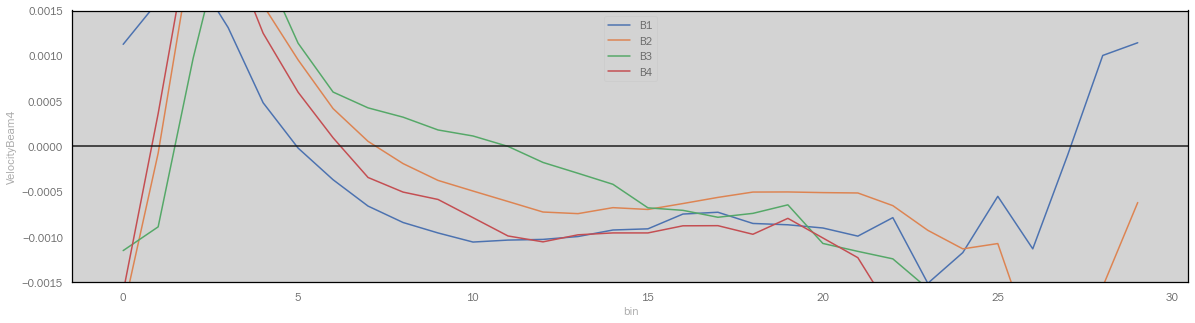

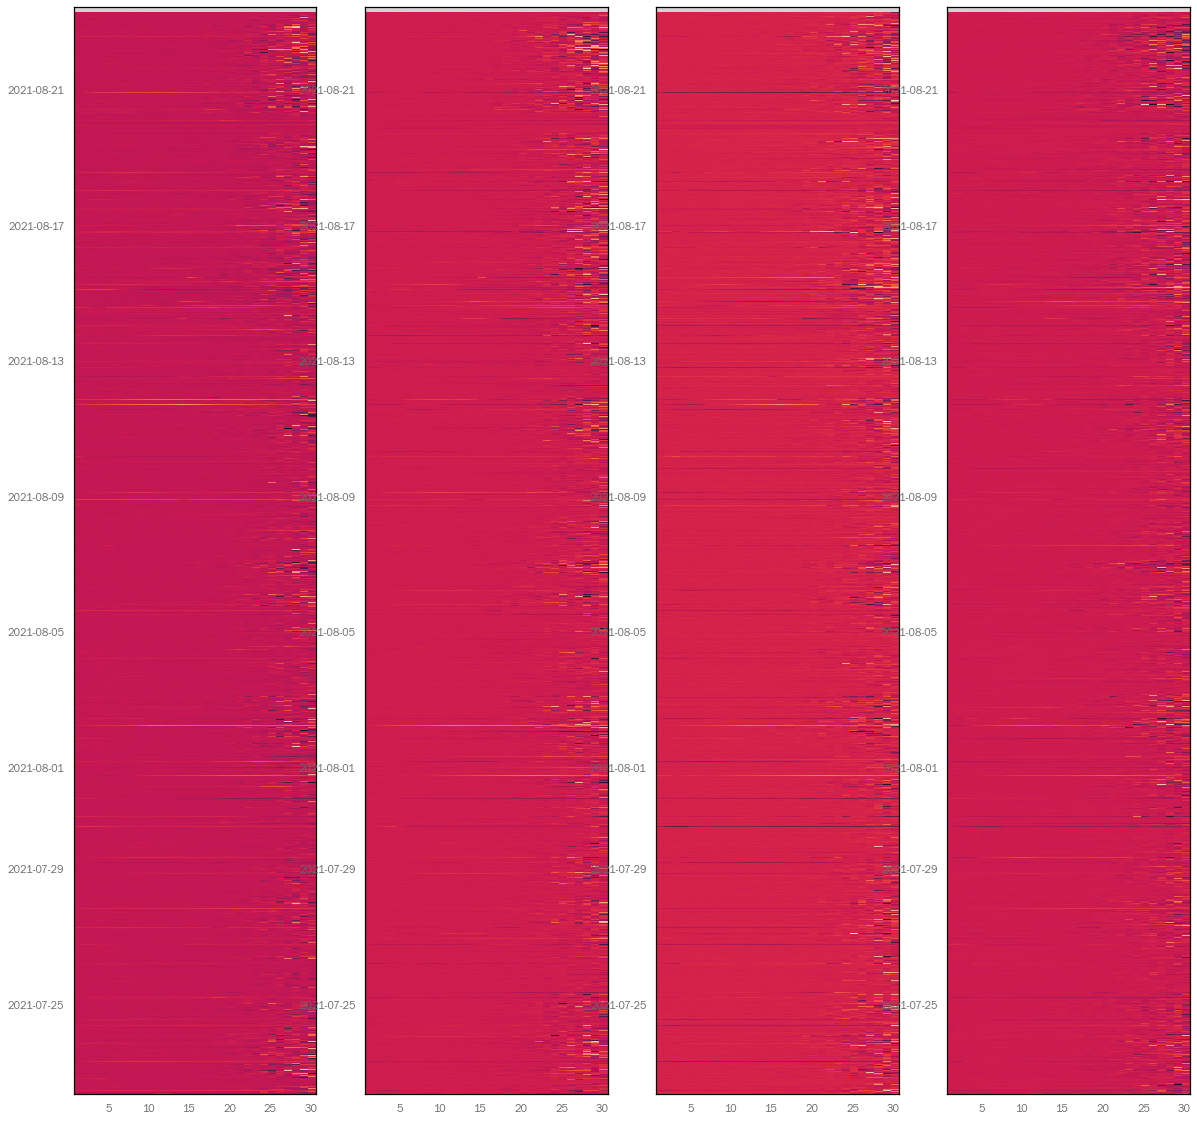

In [11]:
if options['debug']:
    plt.figure(figsize=(20,5))
    ADCP['VelocityBeam1'].differentiate(coord='Velocity Range').mean(dim='time').plot()
    ADCP['VelocityBeam2'].differentiate(coord='Velocity Range').mean(dim='time').plot()
    ADCP['VelocityBeam3'].differentiate(coord='Velocity Range').mean(dim='time').plot()
    ADCP['VelocityBeam4'].differentiate(coord='Velocity Range').mean(dim='time').plot()
    plt.legend(('B1','B2','B3','B4'))
    plt.axhline(0,color='k')
    plt.ylim(np.array([-1,1])*1.5e-3)
    
    plt.figure(figsize=(20,20))
    
    plt.subplot(141)
    plt.pcolormesh(ADCP['Velocity Range'], ADCP['time'], ADCP['VelocityBeam1'])
    plt.subplot(142)
    plt.pcolormesh(ADCP['Velocity Range'], ADCP['time'], ADCP['VelocityBeam2'])
    plt.subplot(143)
    plt.pcolormesh(ADCP['Velocity Range'], ADCP['time'], ADCP['VelocityBeam3'])
    plt.subplot(144)
    plt.pcolormesh(ADCP['Velocity Range'], ADCP['time'], ADCP['VelocityBeam4'])

In [12]:
# From Tanaka:
# the velocity was 0.5 m s-1 or less,
# the echo intensity (or amplitude) was 75 dB or less,
# the percent-good was 80 or greater,
# the signal-to-noise ratio (SNR) was 20 or greater.
def prct(ind):
    out = np.count_nonzero(ind)/n*100
    out = np.round(out*10)/10
    return str(out)

for beam in ['1','2','3','4']:    
    C = ADCP['CorrelationBeam'+beam].values.copy()
    n = len(C.flatten())
    ind = C < options['ADCP_correlationThreshold']
    C[ind] = np.NaN
    C[np.isfinite(C)] = 1
    plog('Beam '+beam+' correlation: '+prct(ind)+'% removed')
    
    A = ADCP['AmplitudeBeam'+beam].values.copy()
    ind = A > options['ADCP_amplitudeThreshold']
    A[ind] = np.NaN
    # A[A < 40] = np.NaN
    A[np.isfinite(A)] = 1
    plog('Beam '+beam+' amplitude: '+prct(ind)+'% removed')
    
    V = ADCP['VelocityBeam'+beam].values.copy()
    ind = np.abs(V) > options['ADCP_velocityThreshold']
    V[ind] = np.NaN
    V[np.isfinite(V)] = 1
    plog('Beam '+beam+' velocity: '+prct(ind)+'% removed')
    
    ADCP['VelocityBeam'+beam] = ADCP['VelocityBeam'+beam]*C*A*V
    

2023-03-22 23:41:21 : Beam 1 correlation: 43.8% removed
2023-03-22 23:41:22 : Beam 1 amplitude: 0.8% removed
2023-03-22 23:41:22 : Beam 1 velocity: 1.7% removed
2023-03-22 23:41:22 : Beam 2 correlation: 44.9% removed
2023-03-22 23:41:22 : Beam 2 amplitude: 0.7% removed
2023-03-22 23:41:22 : Beam 2 velocity: 1.8% removed
2023-03-22 23:41:22 : Beam 3 correlation: 46.0% removed
2023-03-22 23:41:23 : Beam 3 amplitude: 0.7% removed
2023-03-22 23:41:23 : Beam 3 velocity: 2.1% removed
2023-03-22 23:41:23 : Beam 4 correlation: 43.8% removed
2023-03-22 23:41:23 : Beam 4 amplitude: 0.7% removed
2023-03-22 23:41:23 : Beam 4 velocity: 1.7% removed


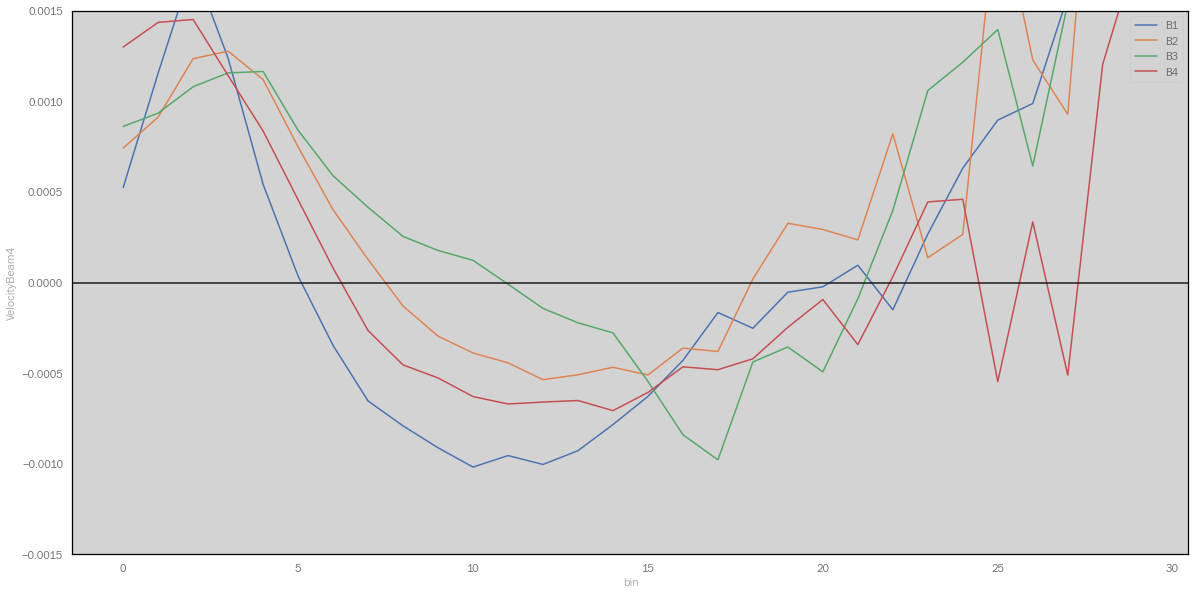

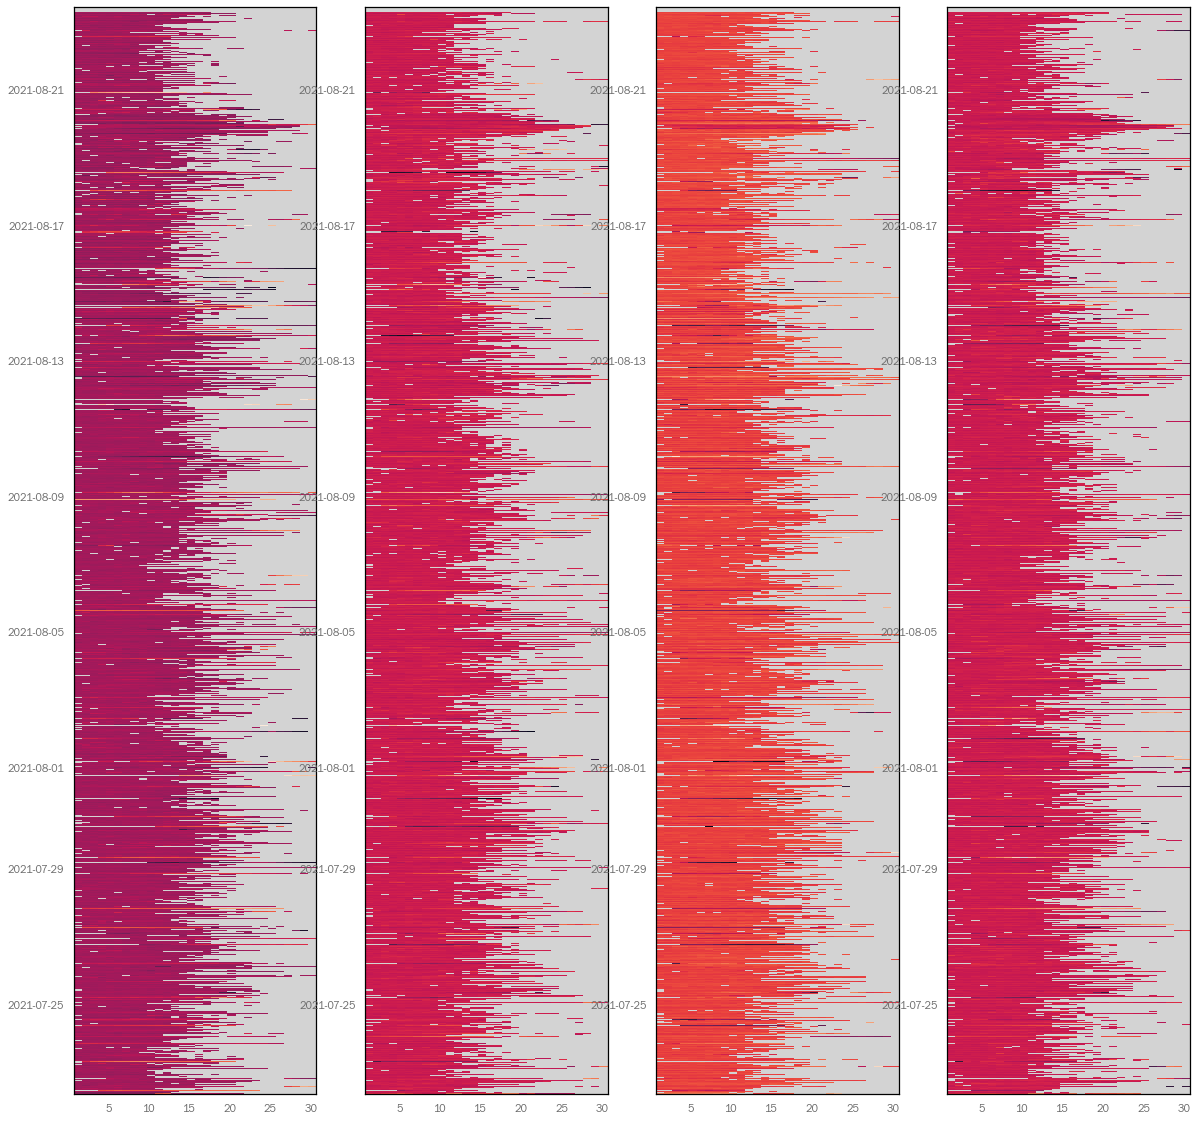

In [13]:
if options['debug']:
    plt.figure(figsize=(20,10))
    ADCP['VelocityBeam1'].differentiate(coord='Velocity Range').mean(dim='time').plot()
    ADCP['VelocityBeam2'].differentiate(coord='Velocity Range').mean(dim='time').plot()
    ADCP['VelocityBeam3'].differentiate(coord='Velocity Range').mean(dim='time').plot()
    ADCP['VelocityBeam4'].differentiate(coord='Velocity Range').mean(dim='time').plot()
    plt.legend(('B1','B2','B3','B4'))
    plt.axhline(0,color='k')
    plt.ylim(np.array([-1,1])*1.5e-3)
    
    plt.figure(figsize=(20,20))
    
    plt.subplot(141)
    plt.pcolormesh(ADCP['Velocity Range'], ADCP['time'], ADCP['VelocityBeam1'])
    plt.subplot(142)
    plt.pcolormesh(ADCP['Velocity Range'], ADCP['time'], ADCP['VelocityBeam2'])
    plt.subplot(143)
    plt.pcolormesh(ADCP['Velocity Range'], ADCP['time'], ADCP['VelocityBeam3'])
    plt.subplot(144)
    plt.pcolormesh(ADCP['Velocity Range'], ADCP['time'], ADCP['VelocityBeam4'])

Should we interpolate over bad data? Reconstruct missing bins in profiles?

# How many good data per bin?

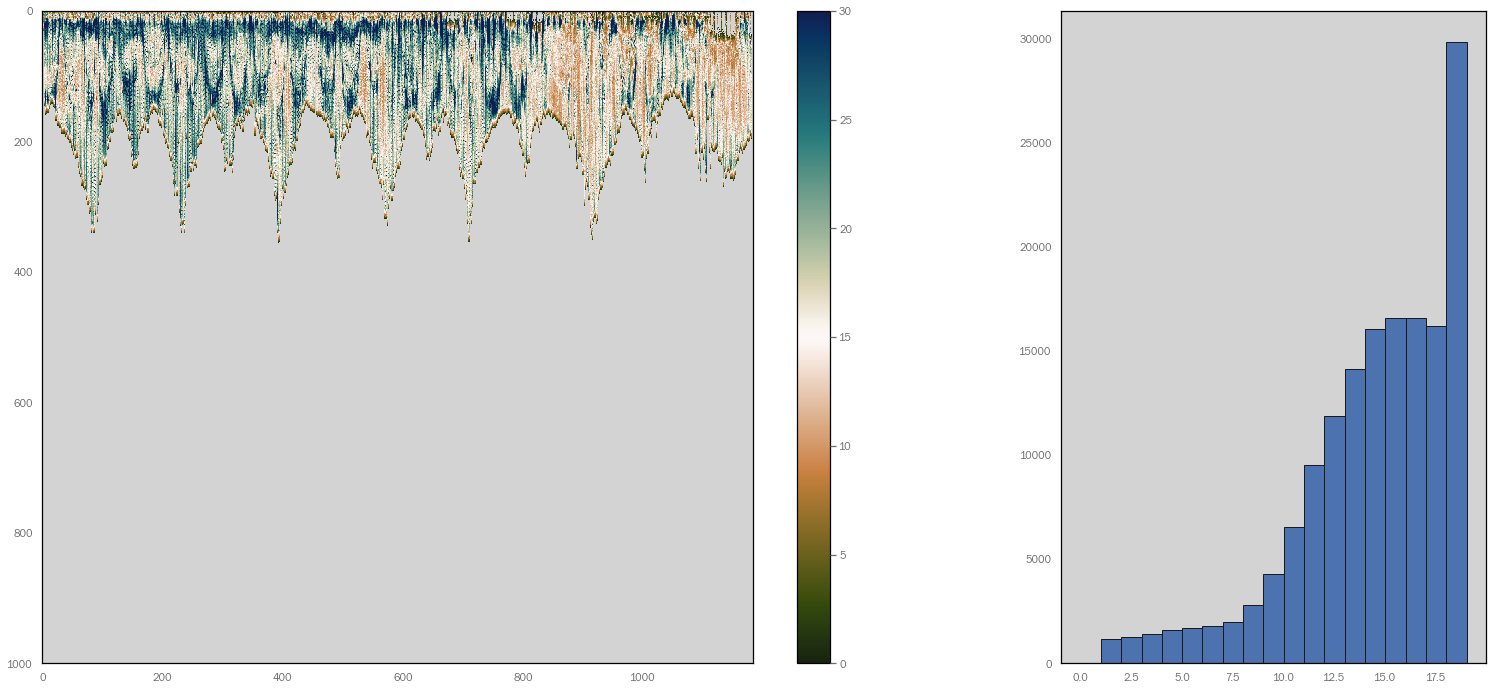

In [14]:
agg_fn = lambda x : np.count_nonzero(np.isfinite(x))

CNT,XI,YI = sx.grid2d(
    np.tile(ADCP.profileNum.values, (len(ADCP.bin), 1)).T.flatten(),
    ADCP['D2'].values.flatten(),
    ADCP['VelocityBeam2'].values.flatten(), 
    xi=1, yi=np.arange(0,1000,bin_size), fn=agg_fn)

plt.figure(figsize=(35,12))
plt.subplot(121)
plt.pcolormesh(CNT, cmap=cmo.tarn)
plt.colorbar()
plt.gca().invert_yaxis()
plt.clim(0,30)

plt.subplot(143)
_ = plt.hist(CNT.flatten(), np.arange(0,20))

### Correct shear bias

In [15]:
### Defining coordinate transform functions for the 4 beam ADCP configuration
def quad_beam2xyzz_mat():
    # M11=0.6782; M12=0.0000; M13=-0.6782; M14=0.0000
    # M21=0.0000; M22=-1.1831; M23=0.0000; M24=1.1831
    # M31=0.7400; M32=0.0000; M33=0.7400; M34=0.0000
    # M41=0.0000; M42=0.5518; M43=0.0000; M44=0.5518
    M11=0.6782; M12=0.0000; M13=-0.6782; M14=0.0000
    M21=0.0000; M22=-1.1831; M23=0.0000; M24=1.1831
    M31=0.7400; M32=0.0000; M33=0.7400; M34=0.0000
    M41=0.0000; M42=0.5518; M43=0.0000; M44=0.5518
    T = np.array([[M11,M12,M13,M14], [M21,M22,M23,M24], [M31,M32,M33,M34], [M41,M42,M43,M44]])
    # if not top_mounted:
    #     T[1:,:] = -T[1:,:]
    return T

def quad_beam2xyzz(B1,B2,B3,B4):
    T = quad_beam2xyzz_mat()
    try:
        r,c = np.shape(B1.values)
    except:
        c = 1; r = len(B1.values)
    V = np.array([B1.values.flatten(),
                  B2.values.flatten(),
                  B3.values.flatten(),
                  B4.values.flatten()
                 ])
    XYZZ = V*0
    for col in np.arange(V.shape[1]):
        XYZZ[:,col] = T@V[:,col]   
    return np.reshape(XYZZ[0,:],[r,c]),np.reshape(XYZZ[1,:],[r,c]),np.reshape(XYZZ[2,:],[r,c]),np.reshape(XYZZ[3,:],[r,c])

def quad_xyzz2beam(X,Y,Z,ZZ):
    T = np.linalg.inv(quad_beam2xyzz_mat())
    r,c = np.shape(X.values)
    XYZZ = np.array([X.values.flatten(),
                  Y.values.flatten(),
                  Z.values.flatten(),
                  ZZ.values.flatten()
                 ])
    V = XYZZ*0
    for col in np.arange(XYZZ.shape[1]):
        V[:,col] = T@XYZZ[:,col]   
    return np.reshape(V[0,:],[r,c]),np.reshape(V[1,:],[r,c]),np.reshape(V[2,:],[r,c]),np.reshape(V[3,:],[r,c])

def do_xyzz2beam(ADCP):
    V = quad_xyzz2beam(ADCP['X4'],ADCP['Y4'],ADCP['Z4'],ADCP['ZZ4'])
    ADCP['VelocityBeam1'] = (['time','bin'], V[0])
    ADCP['VelocityBeam2'] = (['time','bin'], V[1])
    ADCP['VelocityBeam3'] = (['time','bin'], V[2])
    ADCP['VelocityBeam4'] = (['time','bin'], V[3])
    return ADCP
    
def do_beam2xyzz(ADCP):
    XYZZ = quad_beam2xyzz(ADCP['VelocityBeam1'],ADCP['VelocityBeam2'],ADCP['VelocityBeam3'],ADCP['VelocityBeam4'])
    ADCP['X4'] = (['time','bin'], XYZZ[0])
    ADCP['Y4'] = (['time','bin'], XYZZ[1])
    ADCP['Z4'] = (['time','bin'], XYZZ[2])
    ADCP['ZZ4'] = (['time','bin'], XYZZ[3])
    return ADCP

def plotit():
    plt.figure(figsize=(7,3))
    ADCP['X4'].differentiate(coord='Velocity Range').mean(dim='time').plot()
    ADCP['Y4'].differentiate(coord='Velocity Range').mean(dim='time').plot()
    ADCP['Z4'].differentiate(coord='Velocity Range').mean(dim='time').plot()
    ADCP['ZZ4'].differentiate(coord='Velocity Range').mean(dim='time').plot()
    plt.legend(('X','Y','Z','ZZ'))
    plt.ylim(np.array([-1,1])*1.5e-3)

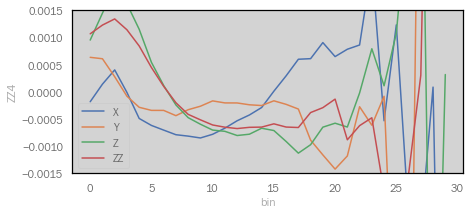

In [16]:
def shear_correction(var,correct=True):
    def get_correction_array(row):
        ### SEPARATION CRITERIA
        spd_thr_water = np.sqrt(ADCP['X4']**2 + ADCP['Y4']**2 + ((ADCP['Z4']+ADCP['ZZ4'])/2)**2)

        spd = spd_thr_water.values[:,0] #.values[:,5] #.mean('bin')

        range_interval = 0.01
        full_range = np.arange(0.2,0.3,range_interval)   # OMAN BEST: np.arange(0.2,0.3,range_interval)
        cmaps = np.arange(len(full_range))/len(full_range)

        ### WHAT TO PLOT
        variable = ADCP[var]
        _gd = (ADCP['Depth'] > 5)

        ### MAKE FIGURE
        colormap = cmo.speed
        alpha = 30/len(full_range)
        if alpha > 1.:
            alpha=0.5

        plt.subplot(2,3,1+row)
        sz = plt.hist(spd, bins = np.append(full_range, np.max(full_range)+range_interval)-(range_interval/2))[0]
        sz = sz/np.max(sz) * 50

        plt.subplot(2,3,2+row)
        x = []; y = []; c = []; s = []
        for idx,range_level in enumerate(full_range):
            color = colormap(cmaps[idx])
            ind = (np.abs(spd-range_level) < (range_interval/2)) & _gd
            arr = variable.isel(time=ind).mean('time').values
            plt.plot(arr, color=color, alpha=alpha)

            x.append(np.arange(len(arr)))
            y.append(arr)
            c.append(arr*0 + range_level)
            s.append(arr*0 + sz[idx])

        plt.plot(variable.isel(time=(spd > full_range[0]) & (spd < full_range[-1])).mean('time').values, color='r', linewidth=4)
        plt.scatter(x,y,s,c, cmap=colormap)
        plt.colorbar()
        plt.grid('on')

        plt.subplot(2,3,3+row)
        x = []; y = []; c = []; s = []
        for idx,range_level in enumerate(full_range):
            color = colormap(cmaps[idx])
            ind = (np.abs(spd-range_level) < (range_interval/2)) & _gd
            arr = variable.isel(time=ind).diff('bin').mean('time').values
            plt.plot(arr, color=color, alpha=alpha)

            x.append(np.arange(len(arr)))
            y.append(arr)
            c.append(arr*0 + range_level)
            s.append(arr*0 + sz[idx])

        plt.plot(variable.isel(time=(spd > full_range[0]) & (spd < full_range[-1])).diff('bin').mean('time').values, color='r', linewidth=4)
        plt.scatter(x,y,s,c, cmap=colormap)
        plt.colorbar()
        plt.axhline(0, color='k')
        plt.grid('on')
        plt.ylim(np.array([-1,1])*0.001)

        
        ref = np.cumsum(np.insert(variable.isel(time=(spd > full_range[0]) & (spd < full_range[-1])).diff('bin').mean('time').values,0,0))
        ref = ref - np.nanmean(ref)
        
        return ref
    
    plt.figure(figsize=(20,6))
    
    if correct:
        ADCP[var] = ADCP[var] - get_correction_array(0)
        _ = get_correction_array(3)
        plog('Corrected '+var)
    else:
        _ = get_correction_array(0)
    
    return None



ADCP = do_beam2xyzz(ADCP)
plotit()

if options['correctZZshear']: ADCP = do_beam2xyzz(ADCP); shear_correction('ZZ4'); ADCP = do_xyzz2beam(ADCP);
if options['correctZshear']: ADCP = do_beam2xyzz(ADCP); shear_correction('Z4'); ADCP = do_xyzz2beam(ADCP);
if options['correctYshear']: ADCP = do_beam2xyzz(ADCP); shear_correction('Y4'); ADCP = do_xyzz2beam(ADCP);
if options['correctXshear']: ADCP = do_beam2xyzz(ADCP); shear_correction('X4'); ADCP = do_xyzz2beam(ADCP);

if options['correctZZshear'] or options['correctZshear'] or options['correctYshear'] or options['correctXshear']: plotit();

### Pitching motion correction (TODO - or not TODO)

In [17]:
# def ADCP_rotation_correction():
#     ADCP['dPitch_dt'] = (['time'], np.gradient(np.deg2rad(ADCP.Pitch.values),ADCP.time.values.astype('float')/(10**9)))
#     dx=0.4
#     dz=0.125
#     a=47.5
#     b=25
#     ADCP['VelocityBeam1'] = ADCP['VelocityBeam1'] + ADCP['dPitch_dt']*(-dz * np.sin(np.deg2rad(a)) + dx * np.cos(np.deg2rad(a)))
#     ADCP['VelocityBeam3'] = ADCP['VelocityBeam3'] + ADCP['dPitch_dt']*( dz * np.sin(np.deg2rad(a)) + dx * np.cos(np.deg2rad(a)))
#     ADCP['VelocityBeam2'] = ADCP['VelocityBeam2'] + ADCP['dPitch_dt']*( dx * np.cos(np.deg2rad(b)) )
#     ADCP['VelocityBeam4'] = ADCP['VelocityBeam4'] + ADCP['dPitch_dt']*( dx * np.cos(np.deg2rad(b)) )

# # ADCP_rotation_correction()
# ### NOT RUNNING AS PROBABLY CODED FOR UPWARD FACING ADCP

In [18]:
if options['ADCP_discardFirstBins']: print(ADCP.dims); ADCP = ADCP.isel(bin = ADCP['bin'] >= options['ADCP_discardFirstBins']); print(ADCP.dims); plog('Discarded first '+str(options['ADCP_discardFirstBins'])+' bins from ADCP data')

## 3.4. Correct ADCP acoustic backscatter data (TODO)

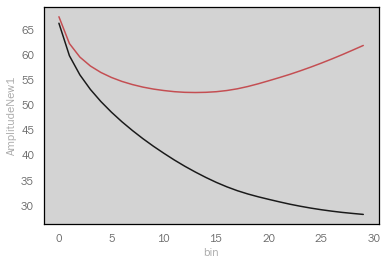

In [19]:
# https://www.sciencedirect.com/science/article/pii/S0278434304002171#fig2
# 2.1. Intensity correction

# For a single acoustic target, intensity falls proportional to distance squared. 
# For volume scattering, on the other hand, approximately half of the loss is 
# cancelled by the increasing number of (zooplankton) targets ensonified by the 
# spreading beam. Defining  and  as the corrected and measured ADCP beam intensity, 
# respectively, the correction for volume scattering is given by

# I(c) = I(m) + 2( 10 * log(r) + alpha * r )

# with r the distance from the transducer to each of the depth bins, alpha the
# absorption, or attenuation, coefficient, and where the extra factor of 2 accounts for 
# the return trip the sound pulse must make. For single target scattering, the correction
# recommended by RDI, the 10 in Eq. (1) is replaced with 20; this correction has been used,
# for example, by Thomson and Allen (2000), who examined macrozooplankton migration and 
# fish abundance. The rate of absorption in seawater is a function of pressure, temperature,
# salinity, pH, and sound frequency; using the empirical equation derived by Francois and 
# Garrison (1982) for a depth of 100 m, , and  for the ADCP frequency of 307 kHz.


def francoisgarrison(freq=None,S=None,T=None,pH=8.1,z=None):
    # Underwater acoustics: calculation of the absorption coefficient
    #
    # SYNTAX: a = francoisgarrison(freq,T,S,pH,z)
    # Units: [freq] = kHz, [T] = Celsius, [S] = ppt, [z] = m, [a] = dB/m
    # 
    # Reference: 
    # Sound absorption based on ocean measurements. Part II: Boric acid contribution 
    # and equation for total absorption 
    # R.E. Francois and G. R. Garrison
    # J. Acoust. Soc. Am. 72(6), December 1982
    
    #*******************************************************************************
    # Faro, Ter Set  7 23:46:58 WEST 2021
    # Written by Orlando Camargo Rodriguez
    #*******************************************************************************
    c   = 1412.0 + 3.21*T + 1.19*S + 0.0167*z
    theta = 273.0 + T
    fxf = freq**2
    f1 = 2.8*np.sqrt(S/35.0)*10**(4.0-1245.0/theta)
    f2 = 8.17*10**(8.0-1990.0/theta)/( 1.0 + 0.0018*(S-35.0) )
    A1 = 8.86/c*10**(0.78*pH-5)
    A2 = 21.44*S/c*( 1.0 + 0.025*T )
    A3 = 3.964e-4 - 1.146e-5*T + 1.45e-7*T**2 - 6.5e-10*T**3
    ind = (T <= 20)
    A3[ind] = 4.937e-4 - 2.59e-5*T[ind] + 9.11e-7*T[ind]**2 - 1.50e-8*T[ind]**3
    P1 = 1.0
    P2 = 1 - 1.35e-4*z + 6.2e-9*z**2
    P3 = 1 - 3.83e-5*z + 4.9e-10*z**2
    alpha = A1*P1*f1*fxf/( f1**2 + fxf ) + A2*P2*f2*fxf/( f2**2 + fxf ) + A3*P3*fxf
    return alpha/1000

def fresnel_distance_alseamar(C, f=1000, d=0.03):
    # f (KHz)	: mean acoustic frequency 
    # C (m/s)	: Medium celerity 
    # d (m)		: Transducer diameter 
    # Rf (m)	: Fresnel distance
  
    # Acoustic wavelength
    f_Hz = 1000 * f  # f in Hertz
    lambda_ = C / f_Hz
    
    # Fresnel distance
    Rf = (d**2) / (2 * lambda_)

    return Rf

a = np.cos(np.deg2rad(47.4)) # Beam 1 and 3 angle from Z 47.5
b = np.cos(np.deg2rad(25))   # Beam 2 and 4 angle from Z 25

ADCP['BeamRange1']=('bin',ADCP['Velocity Range'].values / a )
ADCP['BeamRange2']=('bin',ADCP['Velocity Range'].values / b )
ADCP['BeamRange3']=('bin',ADCP['Velocity Range'].values / a )
ADCP['BeamRange4']=('bin',ADCP['Velocity Range'].values / b )
    
ADCP['AcousticAttenuation'] = ('time', 
                               francoisgarrison(
                                   freq=1000,
                                   S=interp(data.data.Timestamp.values.astype('float'), data.data.salinity.interpolate('index').fillna(method='bfill').values, ADCP.time.values.astype('float')),
                                   T=interp(data.data.Timestamp.values.astype('float'), data.data.temperature.interpolate('index').fillna(method='bfill').values, ADCP.time.values.astype('float')),
                                   pH=8.1,
                                   z=ADCP['Depth'].values)
                              )

for beam in ['1','2','3','4']:
    # ADCP['AmplitudeNew'+beam] = (['time','bin'], (0.43*ADCP['AmplitudeBeam'+beam] + 20*np.log(ADCP['BeamRange'+beam]) + 2*ADCP['AcousticAttenuation']*ADCP['BeamRange'+beam]).values)# + 20 int(particule attenuation,range)
    ADCP['AmplitudeNew'+beam] = (['time','bin'], (ADCP['AmplitudeBeam'+beam] + 2*ADCP['AcousticAttenuation']*ADCP['BeamRange'+beam]).values)# + 20 int(particule attenuation,range)
    
ADCP['AmplitudeBeam1'].mean('time').plot(color='k')
ADCP['AmplitudeNew1'].mean('time').plot(color='r')

In [20]:
# Kc = 0.5; % Count to dB factor for AD2CP. Don't used because raw data already in dB

# f = 1000; % frequency in kHz

# diam = 0.03; % ceramic transducter dimaeter in m for the a2dcp

# Er = 25 % default values but can be adjusted from the calibration sheet or in air measurements

 

# Calcul de distances :
 

# Rf(i,j) = fresnel_distance_alseamar(f,A_Celerity(i),diam);

# Rv_1(i,j) = (Blank + j.*cell_size)./cos((25*2*pi)/360); % 47.5 <-- but not recommended by F. Jourdain

# Rv_3(i,j) = (Blank + j.*cell_size)./cos((25*2*pi)/360); % 47.5 <-- but not recommended by F. Jourdain

# Rv_2(i,j) = (Blank + j.*cell_size)./cos((25*2*pi)/360);

# Rv_4(i,j) = (Blank + j.*cell_size)./cos((25*2*pi)/360);

 

# Calcul du BI en faisant appel à la fonction ‘backscatter_corr_alseamar’ comme suit :
 

# % exemple pour le transduceur 2

# [BI_2(i,j) TL_w_2(i,j) TL_g_2(i,j)]  = backscatter_corr_alseamar(A_Amp2(i,j), Kc, Rv_2(i,j),Er,A_temp(i),A_psal(i), f, A_pres(i),Rf(i,j),'trdi');

 

In [21]:
# import numpy as np
# from scipy.constants import g, pi

# Kc = 0.5 # Count to dB factor for AD2CP. Don't used because raw data already in dB
# f = 1000 # frequency in kHz
# diam = 0.03 # ceramic transducter dimaeter in m for the a2dcp
# Er = 25 # default values but can be adjusted from the calibration sheet or in air measurements

# # dB/m, seawater absorption
# ADCP['AcousticAttenuation'] = ('time', 
#                                francoisgarrison(
#                                    freq=1000,
#                                    S=interp(data.data.Timestamp.values.astype('float'), data.data.salinity.interpolate('index').fillna(method='bfill').values, ADCP.time.values.astype('float')),
#                                    T=interp(data.data.Timestamp.values.astype('float'), data.data.temperature.interpolate('index').fillna(method='bfill').values, ADCP.time.values.astype('float')),
#                                    pH=8.1,
#                                    z=ADCP['Depth'].values)
#                               )  # dB/m, seawater absorption

# def backscatter_corr(RL, Kc, Rv, T, S, f, P, Rf, method=deines):
#     # [BI] = backscatter_corr(RL, Kc, Rv, T, S, f, P, method)
#     # RL (counts)		: Received level
#     # Kc (dB/counts)	: Count to dB conversion factor
#     # Rv (m)		: Acoustic path = R/cos(theta)
#     # T (°C)		: Temperature
#     # S (PSU)		: Salinity
#     # f (kHz)		: Frequency
#     # P (m)		: Sensors depth
#     # Rf (m)      : Frensel distance
#     # method		: BI estimation method (deines or gostiaux)
#     #     
#     # BI (dB)		: Backscatter index
    
# Rv?
# Rf?
    
    
#     TL_w = 2 * ADCP['AcousticAttenuation']  * ADCP['Amplitude Range']

#     # Geometrical spreading loss
#     R1 = Rv / Rf
#     R2 = R1 * 1.35
#     R3 = (R1 * 2.5) ** 3.2
#     R4 = (1 + R2 + R3) / (R2 + R3)

#     tl_g = 20 * np.log10(Rv * R4)
#     TL_g = np.tile(tl_g, (len(alpha_wdb), 1))

#     # Backscatter Index
#     if method == 'gostiaux':
#         BI = 10 * np.log10(10 ** (Kc * RL / 10) - 10 ** (Kc * Er / 10)) + TL_w + TL_g
#     else method == 'deines':
#         BI = Kc * (RL - Er) + TL_w + TL_g
    
#     return BI
        

## 3.5. Remap 3-beam configuration onto isobars

Using the following depth offsets:
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5]
 
Running gridding on all 4 beams:
2023-03-22 23:42:30 : Calculating beam 1
2023-03-22 23:42:47 : Calculating beam 2
2023-03-22 23:43:04 : Calculating beam 3
2023-03-22 23:43:20 : Calculating beam 4


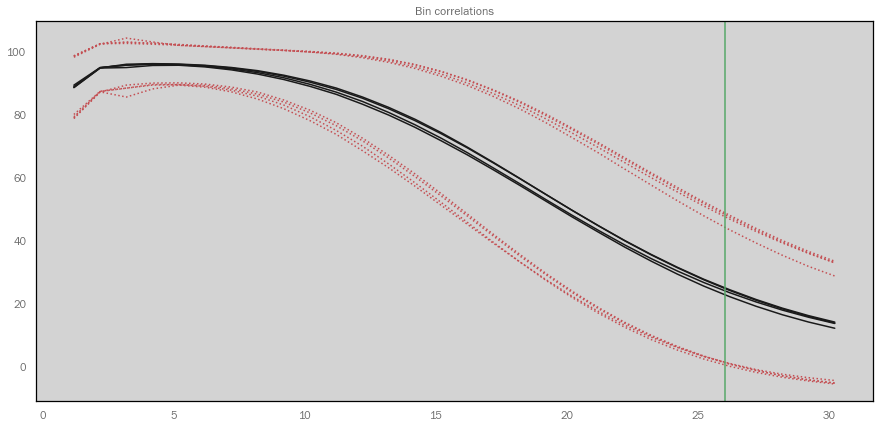

In [22]:
## This is to avoid shear smearing because of tilted ADCP
def regridADCPdata(ADCP, bin_size, blanking_distance, depth_offsets=None):   
    
    ## FN: calculate isobar offsets relative to glider depth for each ping
    def calc_ideal_depth_offsets(bin_size, blanking_distance):
        if top_mounted:
            direction = 1
        else:
            direction = -1
        threshold = 20
        means = [np.nanmean(ADCP['CorrelationBeam'+str(x)],axis=0) for x in [1,2,3,4]]
        stds = [np.nanstd(ADCP['CorrelationBeam'+str(x)],axis=0) for x in [1,2,3,4]]

        max_bin = np.argmin(abs(np.nanmean([means[x] for x in range(4)],axis=0)  - threshold))
        max_distance = blanking_distance + max_bin*bin_size + 0.5*bin_size

        plt.close('all')
        plt.figure(figsize=(15,7))
        [plt.plot(ADCP['Correlation Range'].values,means[x],'-k') for x in range(4)]
        [plt.plot(ADCP['Correlation Range'].values,means[x]+stds[x],':r') for x in range(4)]
        [plt.plot(ADCP['Correlation Range'].values,means[x]-stds[x],':r') for x in range(4)]
        plt.axvline(max_bin,color='g')
        plt.title('Bin correlations')

        return np.arange(0, max_distance+bin_size, bin_size/2)*direction

    ## Calculate desired interpolation depth offsets
    if depth_offsets is None:
        if top_mounted:
            direction = 1
        else:
            direction = -1
        depth_offsets = calc_ideal_depth_offsets(bin_size, blanking_distance)
        
    print('Using the following depth offsets:')
    print(depth_offsets)
    print(' ')
    print('Running gridding on all 4 beams:')
    
    ## Extract to np array for speed
    adcp_depth = ADCP['Depth'].values
        
    for beam in ['1','2','3','4']:
        plog('Calculating beam '+beam)
        def interp1d_np(x,y):
            _gd = np.isfinite(y)
            if np.count_nonzero(_gd) > 1:
                xi = interp1d(x[_gd], y[_gd], bounds_error=False, fill_value=np.NaN)(depth_offsets)
            else:
                xi = depth_offsets * np.NaN
            return xi
        
        ADCP.load()
        ADCP['V'+beam] = xr.apply_ufunc(
            interp1d_np,
            ADCP['Depth']-ADCP['D'+beam],
            ADCP['VelocityBeam'+beam],
            input_core_dims=[['bin'],['bin']],
            output_core_dims=[['gridded_bin']],
            exclude_dims=set(("bin",)),
            vectorize=True,
            output_sizes={'gridded_bin': len(depth_offsets)},
        )        
        
    ADCP = ADCP.assign_coords({'depth_offset':(['gridded_bin'], depth_offsets)})
    ADCP = ADCP.assign_coords({'bin_depth':(['time','gridded_bin'], 
                                     np.tile(ADCP['Depth'].values.astype('float'), (len(ADCP.gridded_bin), 1)).T
                                     - np.tile(depth_offsets, (len(ADCP.time), 1))
                                    )})
    
    ## Discard everything that wasn't gridded
    # ADCP = ADCP.drop(labels=['D1','D2','D3','D4',
    #                          'CorrelationBeam1','CorrelationBeam2','CorrelationBeam3','CorrelationBeam4',
    #                          'VelocityBeam1','VelocityBeam2','VelocityBeam3','VelocityBeam4',
    #                          'AmplitudeBeam1','AmplitudeBeam2','AmplitudeBeam3','AmplitudeBeam4'])
    return ADCP

ADCP = regridADCPdata(ADCP, bin_size, blanking_distance)
# ADCP

In [23]:
ADCP

<xarray.Dataset>
Dimensions:                    (time: 277034, bin: 30, Physicalbeam_dim: 4,
                                gridded_bin: 56)
Coordinates:
  * time                       (time) datetime64[ns] 2021-07-22T08:30:00.4382...
    Velocity Range             (bin) float32 1.2 2.2 3.2 4.2 ... 28.2 29.2 30.2
    Correlation Range          (bin) float32 1.2 2.2 3.2 4.2 ... 28.2 29.2 30.2
    Amplitude Range            (bin) float32 1.2 2.2 3.2 4.2 ... 28.2 29.2 30.2
    Latitude                   (time) float64 58.25 58.25 58.25 ... nan nan nan
    Longitude                  (time) float64 58.25 58.25 58.25 ... nan nan nan
    profileNum                 (time) float64 1.0 1.0 1.0 1.0 ... nan nan nan
    Depth                      (time) float64 0.9243 0.9739 0.9362 ... nan nan
  * bin                        (bin) int32 0 1 2 3 4 5 6 ... 24 25 26 27 28 29
    depth_offset               (gridded_bin) float64 0.0 0.5 1.0 ... 27.0 27.5
    bin_depth                  (time, gridded_bin) float64 0.9243 0.4243 ... nan
Dimensions without coordinates: Physicalbeam_dim, gridded_bin
Data variables: (12/68)
    VelocityBeam1              (time, bin) float64 nan nan nan ... nan nan nan
    VelocityBeam2              (time, bin) float64 nan nan nan ... nan nan nan
    VelocityBeam3              (time, bin) float64 nan nan nan ... nan nan nan
    VelocityBeam4              (time, bin) float64 nan nan nan ... nan nan nan
    CorrelationBeam1           (time, bin) float32 20.0 3.0 0.0 ... 6.0 4.0 0.0
    CorrelationBeam2           (time, bin) float32 2.0 2.0 0.0 ... 2.0 4.0 3.0
    ...                         ...
    AmplitudeNew3              (time, bin) float64 59.27 32.41 32.55 ... nan nan
    AmplitudeNew4              (time, bin) float64 54.07 32.05 32.03 ... nan nan
    V1                         (time, gridded_bin) float64 nan nan ... nan nan
    V2                         (time, gridded_bin) float64 nan nan ... nan nan
    V3                         (time, gridded_bin) float64 nan nan ... nan nan
    V4                         (time, gridded_bin) float64 nan nan ... nan nan

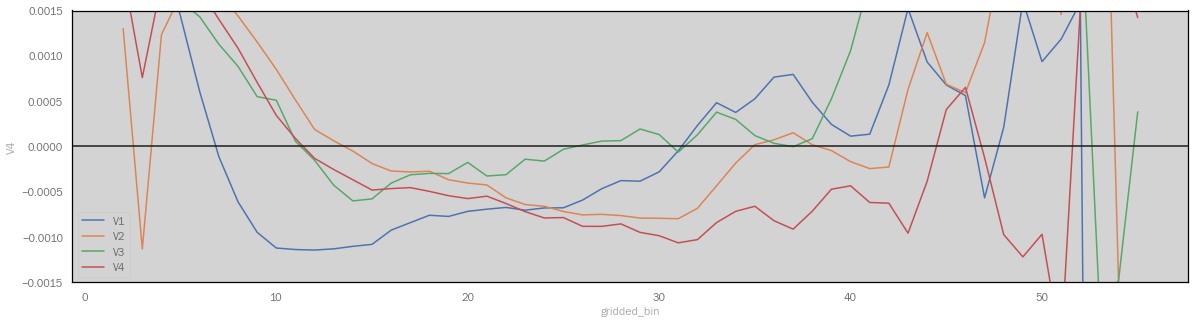

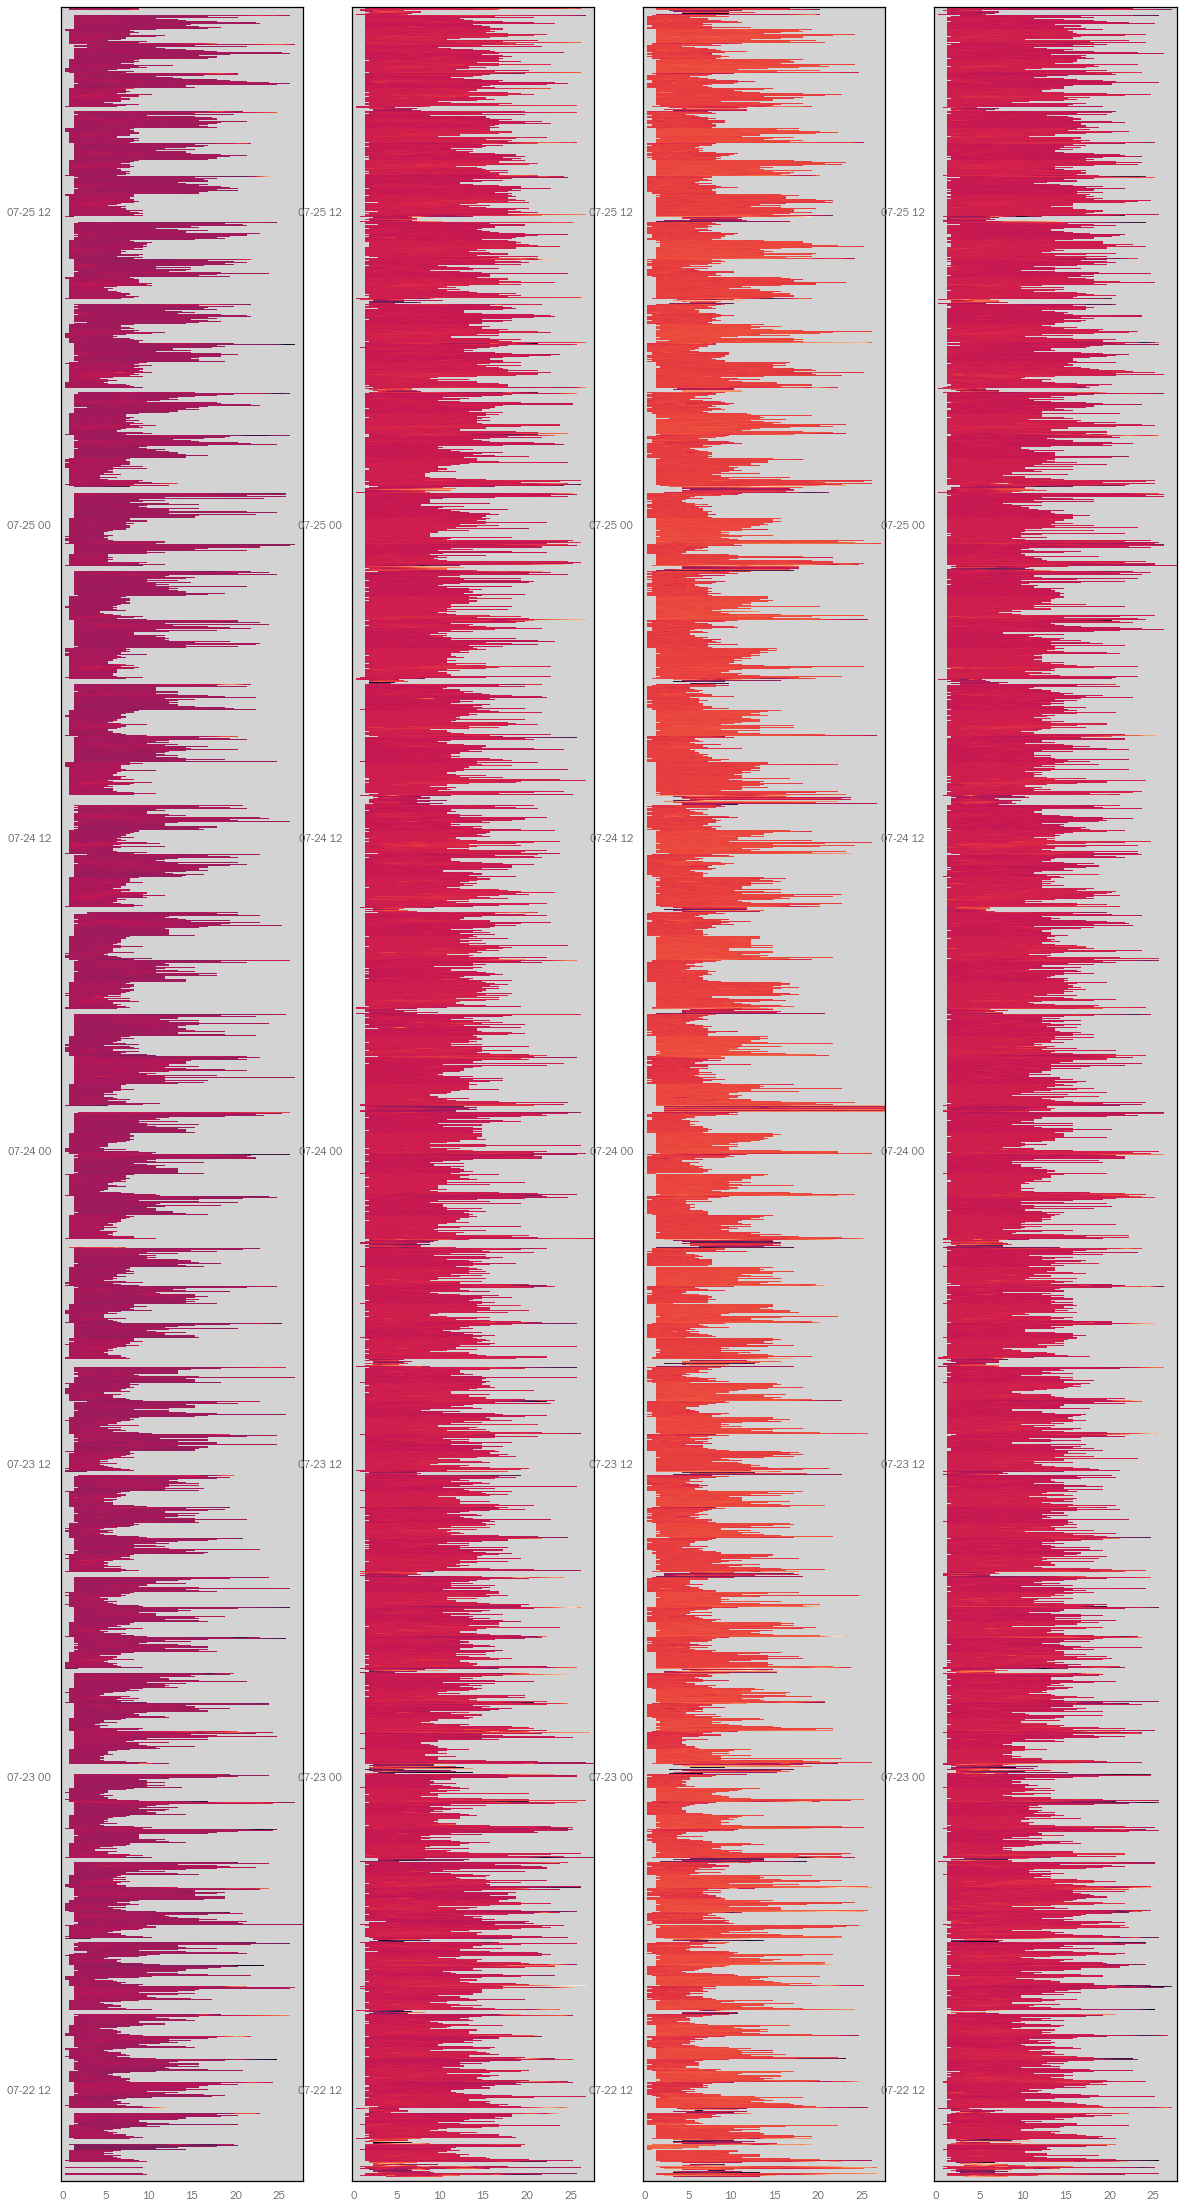

In [24]:

plt.figure(figsize=(20,5))
ADCP['V1'].differentiate(coord='depth_offset').mean(dim='time').plot()
ADCP['V2'].differentiate(coord='depth_offset').mean(dim='time').plot()
ADCP['V3'].differentiate(coord='depth_offset').mean(dim='time').plot()
ADCP['V4'].differentiate(coord='depth_offset').mean(dim='time').plot()
plt.legend(('V1','V2','V3','V4'))
plt.axhline(0,color='k')
plt.ylim(np.array([-1,1])*1.5e-3)

plt.figure(figsize=(20,40))

idx = np.arange(30000)

plt.subplot(141)
plt.pcolormesh(ADCP['depth_offset'], ADCP['time'][idx], ADCP['V1'][idx,:])
plt.subplot(142)
plt.pcolormesh(ADCP['depth_offset'], ADCP['time'][idx], ADCP['V2'][idx,:])
plt.subplot(143)
plt.pcolormesh(ADCP['depth_offset'], ADCP['time'][idx], ADCP['V3'][idx,:])
plt.subplot(144)
plt.pcolormesh(ADCP['depth_offset'], ADCP['time'][idx], ADCP['V4'][idx,:])

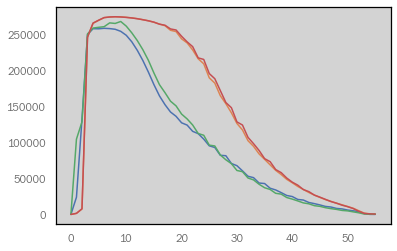

In [25]:
plt.plot(np.nansum(~np.isnan(ADCP['V1']),0))
plt.plot(np.nansum(~np.isnan(ADCP['V2']),0))
plt.plot(np.nansum(~np.isnan(ADCP['V3']),0))
plt.plot(np.nansum(~np.isnan(ADCP['V4']),0))


## 3.6. Transform beams to XYZ and ENU velocities

Assuming ADCP is top mounted
2023-03-22 23:43:47 : Calculating X,Y,Z from isobaric 3-beam measurements.


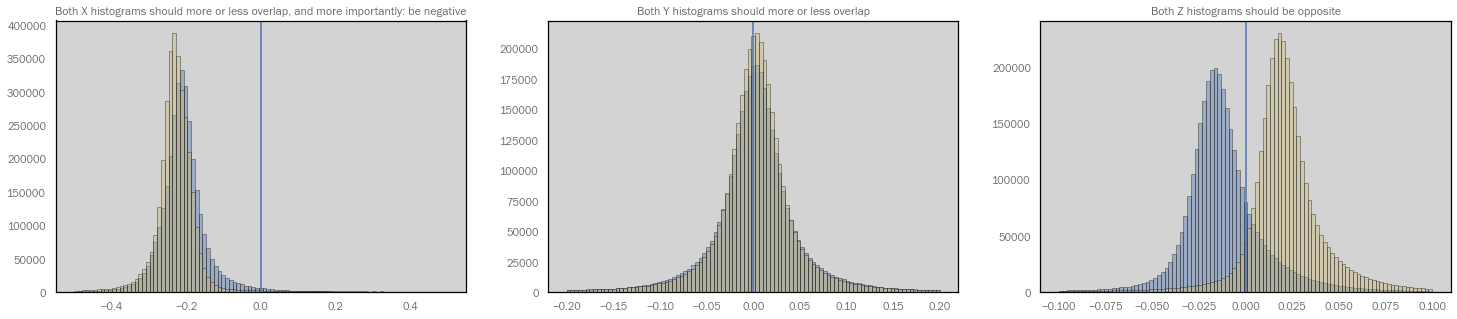

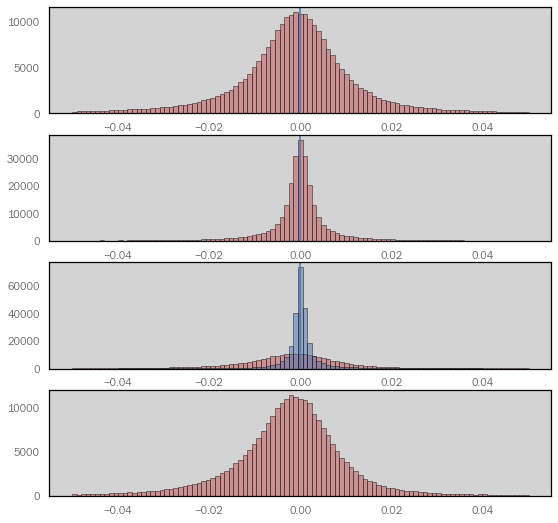

In [26]:
def calcXYZfrom3beam():
    def sin(x):
        return np.sin(np.deg2rad(x))
    def cos(x):
        return np.cos(np.deg2rad(x))

    tf = 47.5 # theta front - Beam 1 and 3 angle from Z
    ts = 25 # theta side - Beam 2 and 4 angle from Z
    
    c = 1 # for convex transducer head
    a = lambda t : 1 / (2 * sin(t))
    b = lambda t : 1 / (4 * cos(t))
    d = lambda t : a(t) / np.sqrt(2)    
    
    V1 = ADCP['V1'].values
    V2 = ADCP['V2'].values   
    V3 = ADCP['V3'].values
    V4 = ADCP['V4'].values

    # Because of duff beam part of the time, we must use the 3 beam solution that relies on error estimation
    # error = d(tf)*V1 + d(tf)*V3 - d(ts)*V2 - d(ts)*V4
    # if error == 0 then...
    # V1 = (-d(tf)*V3 + d(ts)*V2 + d(ts)*V4) / d(tf)
    # V3 = (-d(tf)*V1 + d(ts)*V2 + d(ts)*V4) / d(tf)
    
    # fZ(V1,V3) = fZ(V2,V4) ...
    # 2*b(tf)*V1 + 2*b(tf)*V3 = 2*b(ts)*V2 + 2*b(ts)*V4
    # 0.7400*V1 + 0.7400*V3 = 0.5518*V2 + 0.5518*V4 
    
    
    # replaced_by = lambda good_beam : (-d(tf)*good_beam + d(ts)*V2 + d(ts)*V4) / d(tf)
    # replaced_by = lambda good_beam : (-(0.6782/np.sqrt(2))*good_beam + (1.1831/np.sqrt(2))*V2 + (1.1831/np.sqrt(2))*V4) / (0.6782/np.sqrt(2))
    
    # replaced_by = lambda good_beam : (0.5518*V2 + 0.5518*V4 - 0.7400*good_beam)/0.7400
    replaced_by = lambda good_beam : (2*b(ts)*V2 + 2*b(ts)*V4 - 2*b(tf)*good_beam)/(2*b(tf))

    
    
    
    upcasts = ADCP['Pitch'] > 0
    downcasts = ~upcasts
    
    if top_mounted == True:
        print('Assuming ADCP is top mounted')
        V1[downcasts,:] = replaced_by(V3)[downcasts,:] # Use aft beam on downcasts when upward facing
        V3[upcasts,:] = replaced_by(V1)[upcasts,:] # Use fore beam on upcasts when upward facing
    else:
        print('Assuming ADCP is bottom mounted')
        V1[upcasts,:] = replaced_by(V3)[upcasts,:] # Use aft beam on upcasts when downward facing
        V3[downcasts,:] = replaced_by(V1)[downcasts,:] # Use fore beam on downcasts when downward facing
    
    X = c*a(tf)*V1 - c*a(tf)*V3
    Y = -c*a(ts)*V2 + c*a(ts)*V4 # TODO: sign uncertainty here
    Z = 2*b(ts)*V2 + 2*b(ts)*V4 
    
    # X = c*0.6782*V1 - c*0.6782*V3
    # Y = -c*1.1831*V2 + c*1.1831*V4 # TODO: sign uncertainty here
    # Z = 0.5518*V2 + 0.5518*V4 
    
    
    ADCP['X'] = (['time','gridded_bin'], X )
    ADCP['Y'] = (['time','gridded_bin'], Y )
    ADCP['Z'] = (['time','gridded_bin'], Z )
    
    plt.close('all')
    
    plt.figure(figsize=(25,5))
    plt.subplot(131)
    _ = plt.hist(X[upcasts,:].flatten(),np.linspace(-1,1,100)/2,color='b',alpha=0.4)
    _ = plt.hist(X[~upcasts,:].flatten(),np.linspace(-1,1,100)/2,color='y',alpha=0.4)
    plt.axvline(0)
    plt.title('Both X histograms should more or less overlap, and more importantly: be negative')
    
    plt.subplot(132)
    _ = plt.hist(Y[upcasts,:].flatten(),np.linspace(-1,1,100)/5,color='b',alpha=0.4)
    _ = plt.hist(Y[~upcasts,:].flatten(),np.linspace(-1,1,100)/5,color='y',alpha=0.4)
    plt.axvline(0)
    plt.title('Both Y histograms should more or less overlap')
    
    plt.subplot(133)
    _ = plt.hist(Z[upcasts,:].flatten(),np.linspace(-1,1,100)/10,color='b',alpha=0.4)
    _ = plt.hist(Z[~upcasts,:].flatten(),np.linspace(-1,1,100)/10,color='y',alpha=0.4)
    plt.axvline(0)
    plt.title('Both Z histograms should be opposite')

    
    plt.figure(figsize=(9,9))
    plt.subplot(411)
    _ = plt.hist(ADCP['X'].mean(dim='gridded_bin').values.flatten()-ADCP['X4'].mean(dim='bin').values.flatten(),np.linspace(-1,1,100)/20,color='r',alpha=0.5)
    plt.axvline(0)

    plt.subplot(412)
    _ = plt.hist(ADCP['Y'].mean(dim='gridded_bin').values.flatten()-ADCP['Y4'].mean(dim='bin').values.flatten(),np.linspace(-1,1,100)/20,color='r',alpha=0.5)
    plt.axvline(0)

    plt.subplot(413)
    _ = plt.hist(ADCP['Z'].mean(dim='gridded_bin').values.flatten()-ADCP['Z4'].mean(dim='bin').values.flatten(),np.linspace(-1,1,100)/20,color='r',alpha=0.5)
    _ = plt.hist(ADCP['Z'].mean(dim='gridded_bin').values.flatten()-ADCP['ZZ4'].mean(dim='bin').values.flatten(),np.linspace(-1,1,100)/20,color='b',alpha=0.5)
    plt.axvline(0)

    plt.subplot(414)
    _ = plt.hist(ADCP['ZZ4'].mean(dim='bin').values.flatten()-ADCP['Z4'].mean(dim='bin').values.flatten(),np.linspace(-1,1,100)/20,color='r',alpha=0.5)


    
    plog('Calculating X,Y,Z from isobaric 3-beam measurements.')
    
    
calcXYZfrom3beam()

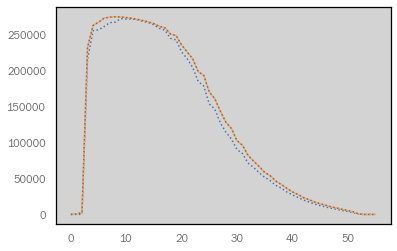

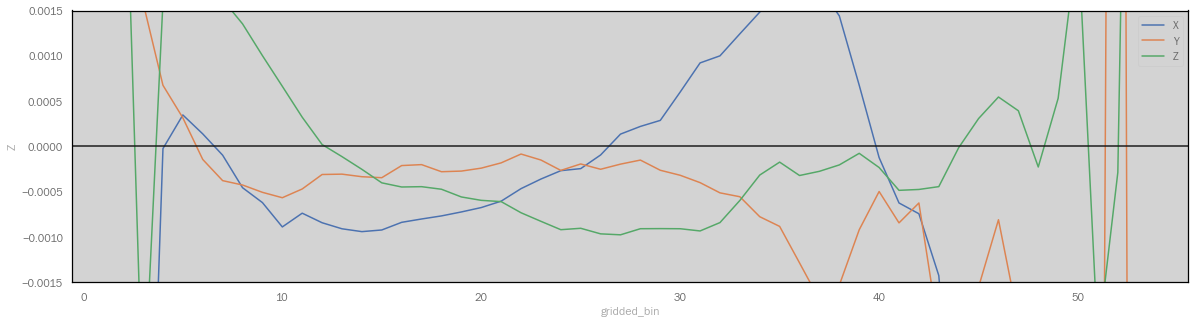

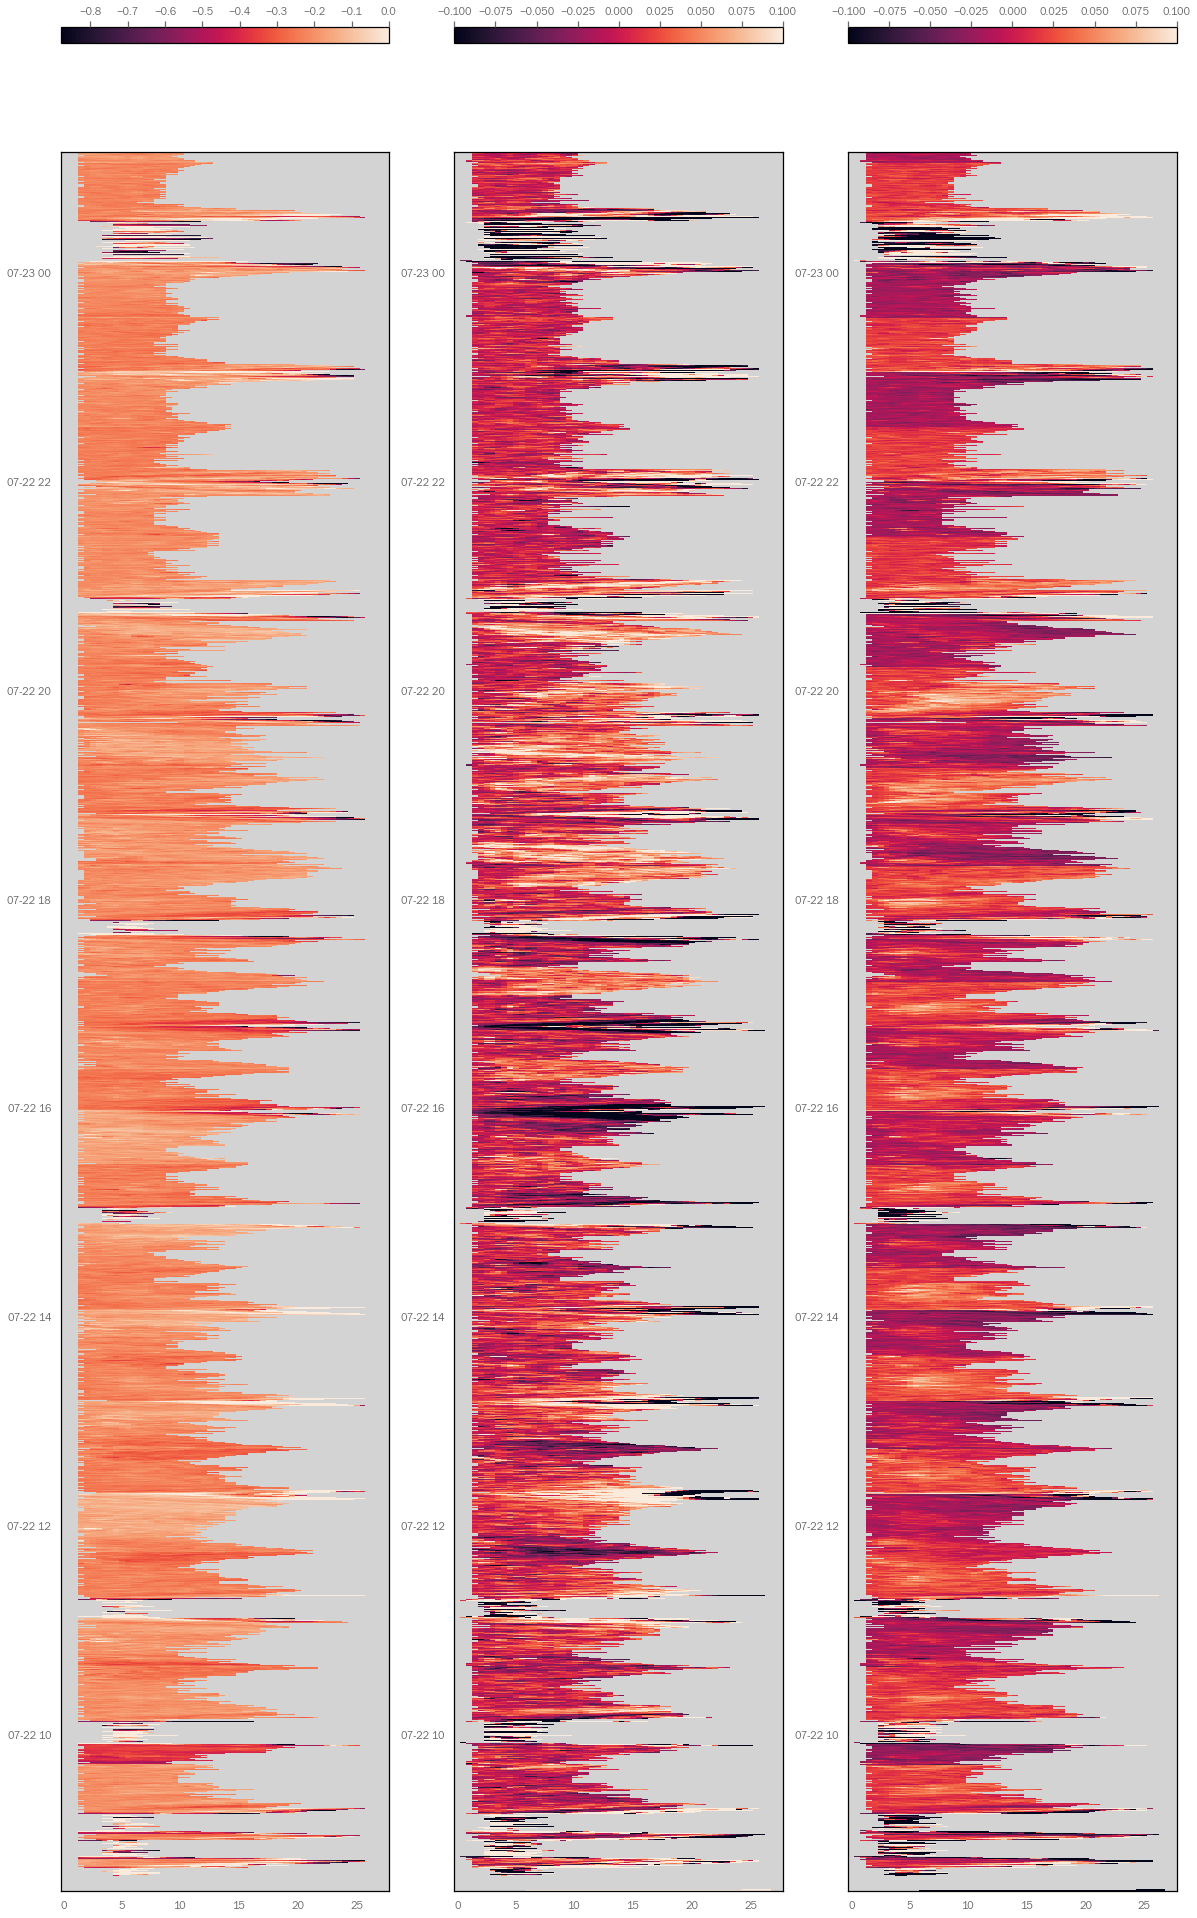

In [27]:
plt.figure()
plt.plot(np.nansum(~np.isnan(ADCP['X']),0),':b')
plt.plot(np.nansum(~np.isnan(ADCP['Y']),0),'-y')
plt.plot(np.nansum(~np.isnan(ADCP['Z']),0),':r')



plt.figure(figsize=(20,5))
ADCP['X'].differentiate(coord='depth_offset').mean(dim='time').plot()
ADCP['Y'].differentiate(coord='depth_offset').mean(dim='time').plot()
ADCP['Z'].differentiate(coord='depth_offset').mean(dim='time').plot()
plt.legend(('X','Y','Z'))
plt.axhline(0,color='k')
plt.ylim(np.array([-1,1])*1.5e-3)

plt.figure(figsize=(20,40))

idx = np.arange(6000)

plt.subplot(131)
plt.pcolormesh(ADCP['depth_offset'], ADCP['time'][idx], ADCP['X'][idx,:])
plt.colorbar(location='top')
plt.clim([0,-0.8])
plt.subplot(132)
plt.pcolormesh(ADCP['depth_offset'], ADCP['time'][idx], ADCP['Y'][idx,:])
plt.colorbar(location='top')
plt.clim([-0.1,0.1])
plt.subplot(133)
plt.pcolormesh(ADCP['depth_offset'], ADCP['time'][idx], ADCP['Z'][idx,:])
plt.colorbar(location='top')
plt.clim([-0.1,0.1])

2023-03-23 00:00:19 : Converted from XYZ to ENU


(-0.2, 0.2)

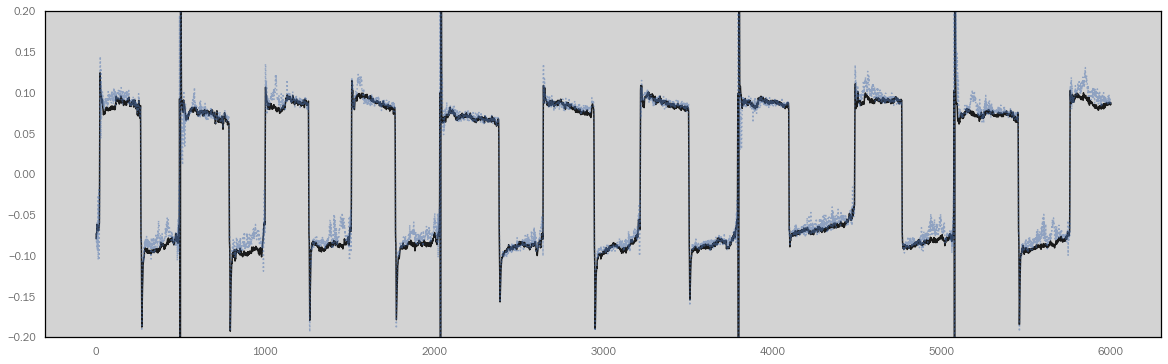

In [60]:
def calcENUfromXYZ():
    def M_xyz2enu(H,P,R):
        def sin(x):
            return np.sin(np.deg2rad(x))
        def cos(x):
            return np.cos(np.deg2rad(x))
        
        CH = cos(H); SH = sin(H)
        # CP = cos(P); SP = sin(P)
        # CR = cos(R); SR = sin(R)
        CP = cos(R); SP = sin(R)
        CR = cos(P); SR = sin(P)
        
        M = [[ CH*CR+SH*SP*SR, SH*CP, CH*SR-SH*SP*CR ],
             [ -SH*CR+CH*SP*SR, CH*CP, -SH*SR-CH*SP*CR ],
             [ -CP*SR, SP, CP*CR ]] # [2][1] = SP
        
        return M

    if top_mounted:
        direction = -1
    else:
        direction = -1
        
    H = ADCP['Heading']
    P = ADCP['Pitch']*direction
    R = ADCP['Roll']*direction
    M = M_xyz2enu(H,P,R)

    E = M[0][0]*ADCP['X'] + M[0][1]*ADCP['Y'] + M[0][2]*ADCP['Z']
    N = M[1][0]*ADCP['X'] + M[1][1]*ADCP['Y'] + M[1][2]*ADCP['Z']
    U = M[2][0]*ADCP['X'] + M[2][1]*ADCP['Y'] + M[2][2]*ADCP['Z']
    
    ADCP['E'] = E
    ADCP['N'] = N
    ADCP['U'] = U
    
    plog('Converted from XYZ to ENU')

calcENUfromXYZ()

_gd = (ADCP['Pressure'].values > 5)
U = ADCP.isel(time=_gd)['U'].mean(dim='gridded_bin').values.flatten()
dP = np.gradient(ADCP.isel(time=_gd)['Depth'].values, ADCP.isel(time=_gd)['time'].astype('float')/1e9)

plt.figure(figsize=(20,6))
plt.plot(dP[10000:16000],'-k')
plt.plot(U[10000:16000],':b', alpha=0.5)
plt.ylim([-0.2,0.2])


131105 126823


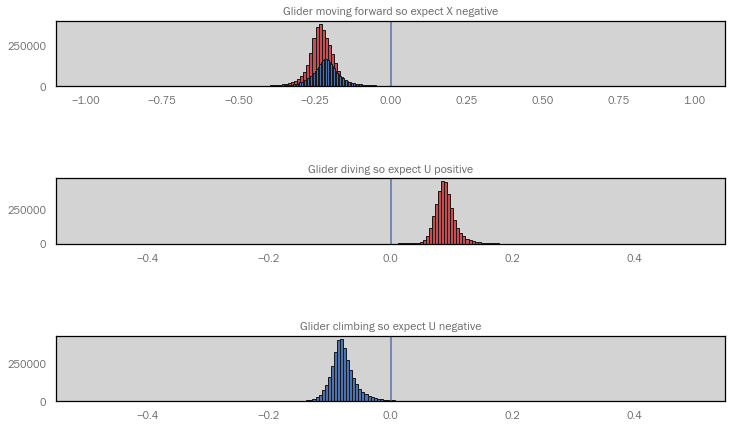

In [61]:
def verify():
    plt.figure(figsize=(12,7))

    PD = (ADCP['Pitch'].values < 0) & (ADCP['Depth'].values > 20)
    PU = (ADCP['Pitch'].values > 0) & (ADCP['Depth'].values > 20)

    print(np.count_nonzero(PD),np.count_nonzero(PU))

    plt.subplot(511)
    _ = plt.hist(ADCP.isel(time=PD)['X'].values.flatten(),np.linspace(-1,1,200),color='r')
    _ = plt.hist(ADCP.isel(time=PU)['X'].values.flatten(),np.linspace(-1,1,200)/2,color='b')
    plt.axvline(0)
    plt.title('Glider moving forward so expect X negative')

    plt.subplot(513)
    _ = plt.hist(ADCP.isel(time=PD)['U'].values.flatten(),np.linspace(-1,1,200)/2,color='r')
    plt.axvline(0)
    plt.title('Glider diving so expect U positive')

    plt.subplot(515)
    _ = plt.hist(ADCP.isel(time=PU)['U'].values.flatten(),np.linspace(-1,1,200)/2,color='b')
    plt.axvline(0)
    plt.title('Glider climbing so expect U negative')
    
verify()

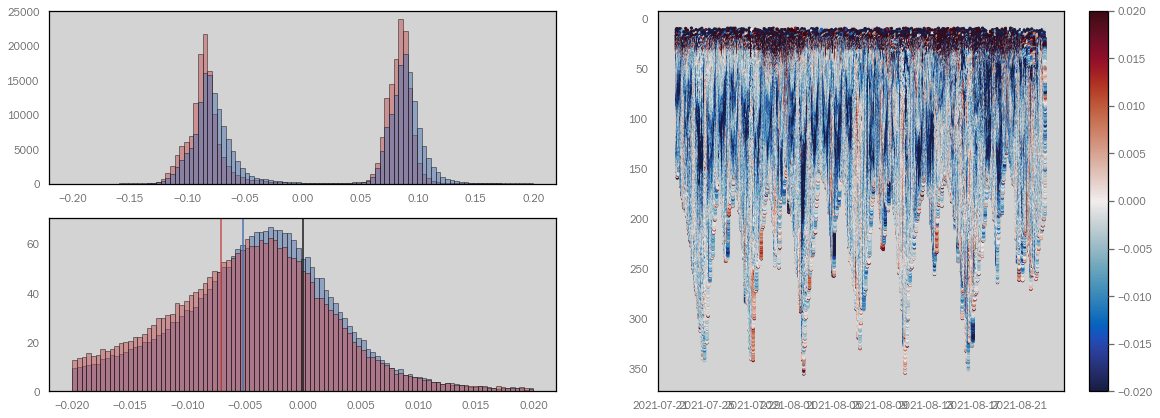

In [62]:
def _verify():

    _gd = (ADCP['Pressure'].values > 10)
    
    PD = (ADCP.isel(time=_gd)['Pitch'].values < 0) & (ADCP.isel(time=_gd)['Depth'].values > 20)
    PU = (ADCP.isel(time=_gd)['Pitch'].values > 0) & (ADCP.isel(time=_gd)['Depth'].values > 20)

    T = ADCP.isel(time=_gd)['time']
    D = ADCP.isel(time=_gd)['Depth']
    R = ADCP.isel(time=_gd)['Roll']
    U = ADCP.isel(time=_gd)['U'].mean(dim='gridded_bin').values.flatten()
    dP = np.gradient(ADCP.isel(time=_gd)['Depth'].values, ADCP.isel(time=_gd)['time'].astype('float')/1e9)
    
    bins = np.linspace(-1,1,100)*0.2
    
    plt.figure(figsize=(20,7))
    plt.subplot(221)
    _ = plt.hist(dP, bins, color='r', alpha=0.5)
    _ = plt.hist(U, bins, color='b', alpha=0.5)
    
    plt.subplot(223)
    _ = plt.hist((dP-U)[PD],bins/10,density=True,color='b',alpha=0.5)
    _ = plt.hist((dP-U)[PU],bins/10,density=True,color='r',alpha=0.5)
    plt.axvline(np.nanmean((dP-U)[PD]),color='b')
    plt.axvline(np.nanmean((dP-U)[PU]),color='r')
    plt.axvline(0,color='k')
    
    plt.subplot(122)
    plt.scatter(T,D,5,dP-U, cmap=cmo.balance)
    plt.colorbar()
    plt.clim([bins[0]/10,bins[-1]/10])
    plt.gca().invert_yaxis()
    
    
_verify()

### Mismatch above sign of misalignment of ADCP / incorrect pitch/roll ?

In [63]:
plt.close('all')

## 3.7. Calculate shear

In [64]:
ADCP['Sh_E'] = (['time','gridded_bin'],
                  ADCP['E'].differentiate('gridded_bin').values
                 )
ADCP['Sh_N'] = (['time','gridded_bin'],
                  ADCP['N'].differentiate('gridded_bin').values
                 )
ADCP['Sh_U'] = (['time','gridded_bin'],
                  ADCP['U'].differentiate('gridded_bin').values
                 )

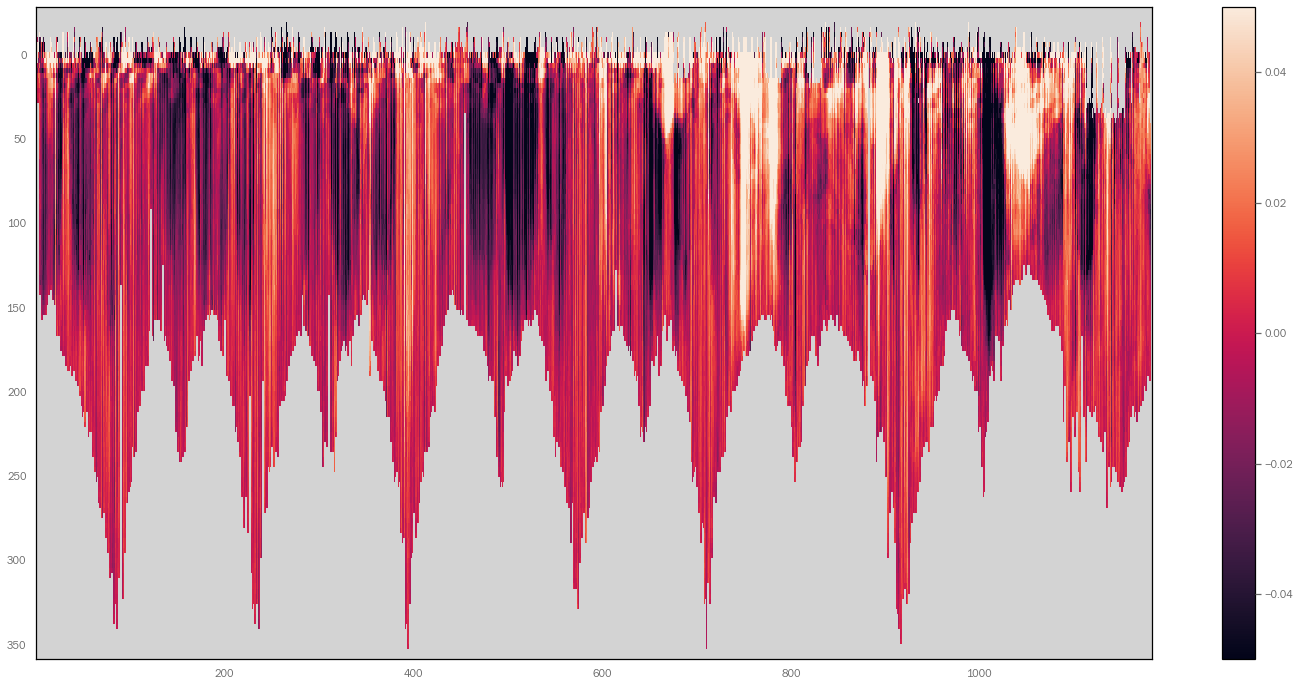

In [78]:
x = np.arange(0,np.shape(ADCP.Sh_E.values)[0],1)
SHEm,XI,YI = sx.grid2d(
    np.tile(ADCP.profileNum.values, (len(ADCP.gridded_bin), 1)).T[x,:].flatten(),
    ADCP.bin_depth.values[x,:].flatten(), 
    ADCP.Sh_E.values[x,:].flatten(), 
    xi=1, yi=3, fn=np.nanmean)

isnan = np.isnan(SHEm)
SHEm = np.nancumsum(SHEm[::-1,:],0)[::-1,:]
SHEm[isnan] = np.NaN

plt.figure(figsize=(25,12))
plt.pcolormesh(XI,YI,SHEm)
plt.gca().invert_yaxis()
plt.colorbar()
plt.clim(np.array([-1,1])*0.05)


## 5.2. Calculate dive-averaged current

No final GPS for dive 590.0


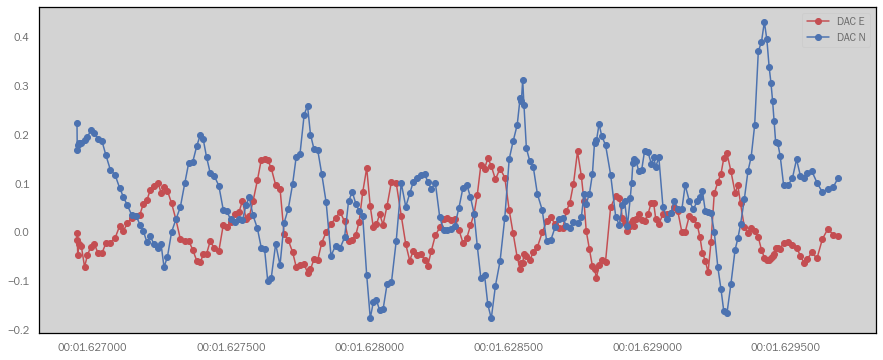

In [33]:
def _getDAC(data):
    ## Calculate full x-y dead reckoning during each dive
    def reset_transport_at_GPS(arr):
        ffill = lambda arr: pd.DataFrame(arr).fillna(method='ffill').values.flatten()
        ref = np.zeros(np.shape(arr)) * np.NaN
        ref[_gps] = arr[_gps]
        return (arr - ffill(ref))
    
    _gps = (data.data.DeadReckoning.values < 1) & (data.data.NAV_RESOURCE.values == 116)
    
    t = data.data.date_float.values * 1e-9
    heading = interp(ADCP['time'].values.astype('float'), ADCP['Heading'].values, data.data.date_float.values)
    vg_e = np.nan_to_num(data.data['speed_horz'] *np.sin( heading * np.pi/180 ))
    vg_n = np.nan_to_num(data.data['speed_horz'] *np.cos( heading * np.pi/180 ))
    
    data.data['speed_e'] = vg_e
    data.data['speed_n'] = vg_n
    
    de = np.cumsum(np.append(0, vg_e[1:] * np.diff(t)))
    dn = np.cumsum(np.append(0, vg_n[1:] * np.diff(t)))

    de = reset_transport_at_GPS(de)
    dn = reset_transport_at_GPS(dn)

    ## Calculate on per dive basis
    dnum = np.unique(data.data.diveNum.values)
    sidx = np.zeros(np.shape(dnum))*np.NaN
    didx = np.zeros(np.shape(dnum))*np.NaN
    
    for idx,dx in enumerate(dnum):
        try:
            sidx[idx] = np.flatnonzero((data.data.diveNum.values == dx) & _gps)[0]
            didx[idx] = np.flatnonzero((data.data.diveNum.values == dx) & _gps)[-1]
        except:
            continue
                        
    _gd = np.isfinite(sidx+didx+dnum)
    dnum = dnum[_gd]
    sidx = sidx[_gd]
    didx = didx[_gd]
    
    sidx = sidx.astype(int)
    didx = didx.astype(int)
   
    surf_lat = data.data.latitude.values[sidx]
    surf_lon = data.data.longitude[sidx]
    surf_time = t[sidx]

    dive_lat = data.data.latitude[didx]
    dive_lon = data.data.longitude[didx]
    dive_time = t[didx]

    dr_e = np.zeros(np.shape(dnum)) * np.NaN
    dr_n = np.zeros(np.shape(dnum)) * np.NaN
    gps_e = np.zeros(np.shape(dnum)) * np.NaN
    gps_n = np.zeros(np.shape(dnum)) * np.NaN
    dt = np.zeros(np.shape(dnum)) * np.NaN
    meant = np.zeros(np.shape(dnum)) * np.NaN

    lon2m = lambda x,y : gsw.distance([x,x+1],[y,y])
    lat2m = lambda x,y : gsw.distance([x,x],[y,y+1])
    
    for idx,dx in enumerate(dnum):
        try:
            dr_e[idx] = de[ sidx[idx+1]-1 ]
            dr_n[idx] = dn[ sidx[idx+1]-1 ]
            gps_e[idx] = (surf_lon[idx+1] - dive_lon[idx]) * lon2m(dive_lon[idx],dive_lat[idx])
            gps_n[idx] = (surf_lat[idx+1] - dive_lat[idx]) * lat2m(dive_lon[idx],dive_lat[idx])
            dt[idx] = surf_time[idx+1] - dive_time[idx]
            meant[idx] = (surf_time[idx+1] + dive_time[idx])/2
        except:
            print('No final GPS for dive '+str(dx))

    dac_e = (gps_e-dr_e)/dt
    dac_n = (gps_n-dr_n)/dt
    
    plt.figure(figsize=(15,6))
    plt.plot(pd.to_datetime(meant),dac_e,'o-r')
    plt.plot(pd.to_datetime(meant),dac_n,'o-b')
    plt.legend(('DAC E','DAC N'))

    data.data['DAC_E'] = interp(meant, (gps_e-dr_e)/dt, t)
    data.data['DAC_N'] = interp(meant, (gps_n-dr_n)/dt, t)
    
    data.data['DAC_E'] = data.data['DAC_E'].fillna(method='bfill').fillna(method='ffill')
    data.data['DAC_N'] = data.data['DAC_N'].fillna(method='bfill').fillna(method='ffill')
    
_getDAC(data)

Text(0.5, 1.0, 'North')

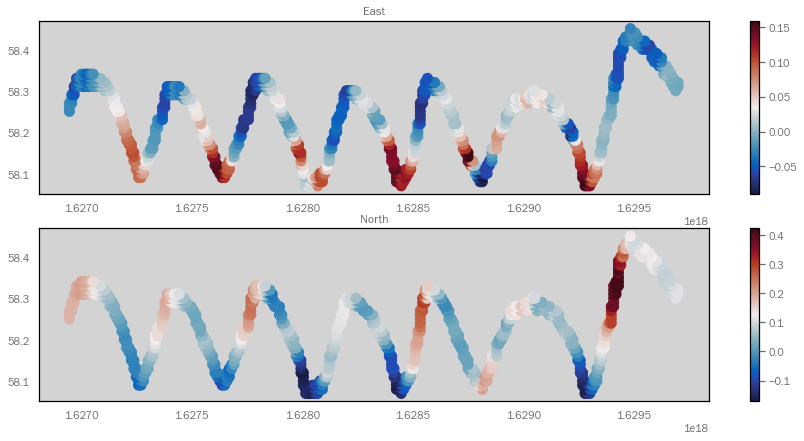

In [34]:
plt.figure(figsize=(15,7))

E,X,Y = sx.grid2d(data.data.Timestamp.values.astype('float'), data.data.latitude, data.data.DAC_E, xi= 10**9 * 60 * 60 * 3, yi=0.01)

N,X,Y = sx.grid2d(data.data.Timestamp.values.astype('float'), data.data.latitude, data.data.DAC_N, xi= 10**9 * 60 * 60 * 3, yi=0.01)

plt.subplot(211)
plt.scatter(X, Y, 100, E, cmap=cmo.balance)
plt.colorbar()
plt.title('East')

plt.subplot(212)
plt.scatter(X, Y, 100, N, cmap=cmo.balance)
plt.colorbar()
plt.title('North')

## 5.3. Get surface drift

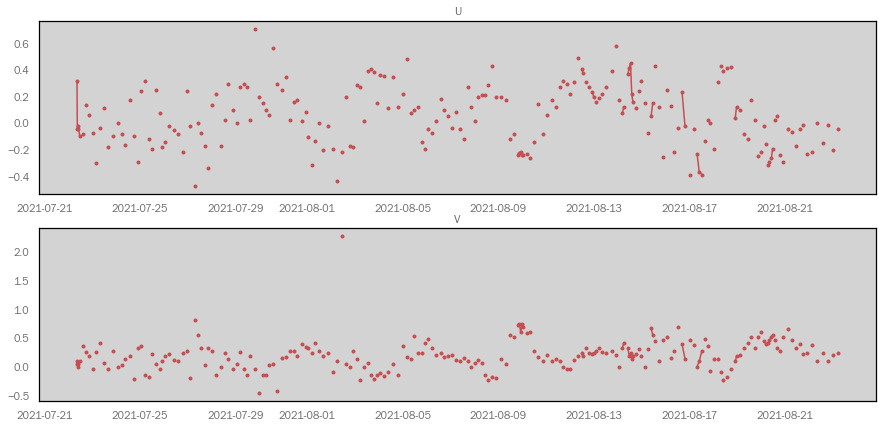

In [35]:
def getSurfaceDrift():
    _gps = (data.data.DeadReckoning.values < 1) & (data.data.NAV_RESOURCE.values == 116)
    
    lon2m = lambda x,y : gsw.distance([x,x+1],[y,y])
    lat2m = lambda x,y : gsw.distance([x,x],[y,y+1])
    
    dnum = data.data.diveNum.values[_gps]
    
    lons = data.data.longitude.values[_gps]
    lats = data.data.latitude.values[_gps]
    
    dlons = np.gradient(lons)
    dlats = np.gradient(lats)
        
    for idx in range(len(lons)):
        dlons[idx] = dlons[idx] * lon2m(lons[idx],lats[idx])
        dlats[idx] = dlats[idx] * lat2m(lons[idx],lats[idx])
    
    times = data.data.Timestamp.values.astype('float')[_gps] / 10**9
    dtimes = np.gradient(times)
    
    dE = np.full(int(np.nanmax(data.data.diveNum)), np.NaN)
    dN = np.full(int(np.nanmax(data.data.diveNum)), np.NaN)
    dT = np.full(int(np.nanmax(data.data.diveNum)), np.NaN)
    
    for idx in range(len(dE)):
        _gd = (dtimes < 21) & (dnum == idx+1)
        dE[idx] = np.nanmedian(dlons[_gd]/dtimes[_gd])
        dN[idx] = np.nanmedian(dlats[_gd]/dtimes[_gd])
        dT[idx] = np.nanmean(times[_gd])
    
    dT = dT * 10**9
    
    plt.figure(figsize=(15,7))
    plt.subplot(211)
    plt.plot(pd.to_datetime(dT),dE,'.-r')
    plt.title('U')
    plt.subplot(212)
    plt.plot(pd.to_datetime(dT),dN,'.-r')
    plt.title('V')
    
    return dE,dN,dT
    
    
dE,dN,dT = getSurfaceDrift()

## 5.4. Get bottom track data

In [36]:
def _process(ADCP):
    def sin(x):
        return np.sin(np.deg2rad(x))
    def cos(x):
        return np.cos(np.deg2rad(x))
    # BT gives us speed of the glider
    # If we subtract BT velocity from XYZ
    # then we get speed of water
    BT = xr.open_mfdataset(adcp_path,group='Data/AverageBT')

    thresh = 12

    ind = (BT['VelocityBeam1'] > -2) & (BT['VelocityBeam2'] > -2) & (BT['VelocityBeam4'] > -2)
    ind2 = (BT['FOMBeam1'] < thresh) & (BT['FOMBeam2'] < thresh) & (BT['FOMBeam4'] < thresh)
    BT = BT.isel(time=ind & ind2)
    
    full_time = ADCP['time'].values.astype('float')
    BT_time = BT['time'].values.astype('float')
    matching = []
    for idx in tqdm(range(len(BT_time))):
        matching.append( np.argmin( np.abs(BT_time[idx]-full_time) ) )
        
    ADCP_profile = ADCP['profileNum'].values.copy()
    ADCP_depth = ADCP['Pressure'].values.copy()
    for idx in range( np.nanmax(ADCP_profile).astype(int) ):
        _gd = (ADCP_profile == idx)
        if np.count_nonzero(_gd) == 0:
            print('Profile '+str(idx)+' was empy')
        else:
            ADCP_depth[_gd] = np.nanmax(ADCP_depth[_gd])
    ADCP_depth = ADCP_depth[matching]
    
    
    _gd = (np.abs(ADCP_depth-BT['Pressure']).values < 15)
    BT = BT.isel(time=_gd)
    full_time = ADCP['time'].values.astype('float')
    BT_time = BT['time'].values.astype('float')
    matching = []
    for idx in tqdm(range(len(BT_time))):
        matching.append( np.argmin( np.abs(BT_time[idx]-full_time) ) )
    
    C_old = BT['SpeedOfSound'].values
    C_new = ADCP['SpeedOfSound'].isel(time=matching).values
    
    a = 47.5 # Beam 1 and 3 angle from Z
    b = 25 # Beam 2 and 4 angle from Z
    xyz2beam_fore = np.array([
        [sin(a),0,cos(a)],
        [0,-sin(b),cos(b)],
        [0,sin(b),cos(b)]
    ])
    beam2xyz_fore = np.linalg.inv(xyz2beam_fore)
    
    BT_X4, BT_Y4, BT_Z4 = beam2xyz_fore @ np.array([
        BT['VelocityBeam1'] * (C_new/C_old),
        BT['VelocityBeam2'] * (C_new/C_old),
        BT['VelocityBeam4'] * (C_new/C_old),
        ])

    def M_xyz2enu(heading,pitch,roll):
        hh = np.pi*(heading-90)/180
        pp = np.pi*pitch/180
        rr = np.pi*roll/180

        _H = np.array([
            [np.cos(hh),np.sin(hh),0], 
            [-np.sin(hh),np.cos(hh),0], 
            [0,0,1]
        ])
        _P = np.array([
            [np.cos(pp), 0, -np.sin(pp)] ,
            [0, 1, 0] , 
            [ np.sin(pp), 0, np.cos(pp)]
        ])
        _R = np.array([
            [1, 0, 0] ,
            [0, np.cos(rr), -np.sin(rr)] , 
            [0, np.sin(rr), np.cos(rr)]
        ])

        _M = _H@_P@_R
        return _M

    H = BT['Heading'].values
    P = BT['Pitch'].values
    R = BT['Roll'].values

    BT_E = np.full_like(H,np.NaN)
    BT_N = np.full_like(H,np.NaN)
    BT_U = np.full_like(H,np.NaN)

    if top_mounted:
        direction = 1
    else:
        direction = -1

    n = len(BT_X4)
    for i in tqdm(range(n)):
        BT_E[i], BT_N[i], BT_U[i] = M_xyz2enu(H[i],P[i],R[i]) @ [BT_X4[i], BT_Y4[i]*direction, BT_Z4[i]*direction]   

    bt_e = np.full_like(full_time,np.NaN)
    bt_e[matching] = BT_E
    bt_n = np.full_like(full_time,np.NaN)
    bt_n[matching] = BT_N
    bt_u = np.full_like(full_time,np.NaN)
    bt_u[matching] = BT_U

    ADCP['BT_E'] = ('time', bt_e)
    ADCP['BT_N'] = ('time', bt_n)
    ADCP['BT_U'] = ('time', bt_u)
    
    return ADCP
    
ADCP = _process(ADCP)

100%|█████████████████████████████████████| 1834/1834 [00:02<00:00, 634.22it/s]


Profile 0 was empy
Profile 883 was empy


100%|█████████████████████████████████████| 170/170 [00:00<00:00, 18904.28it/s]


## 5.5. Reference ADCP data

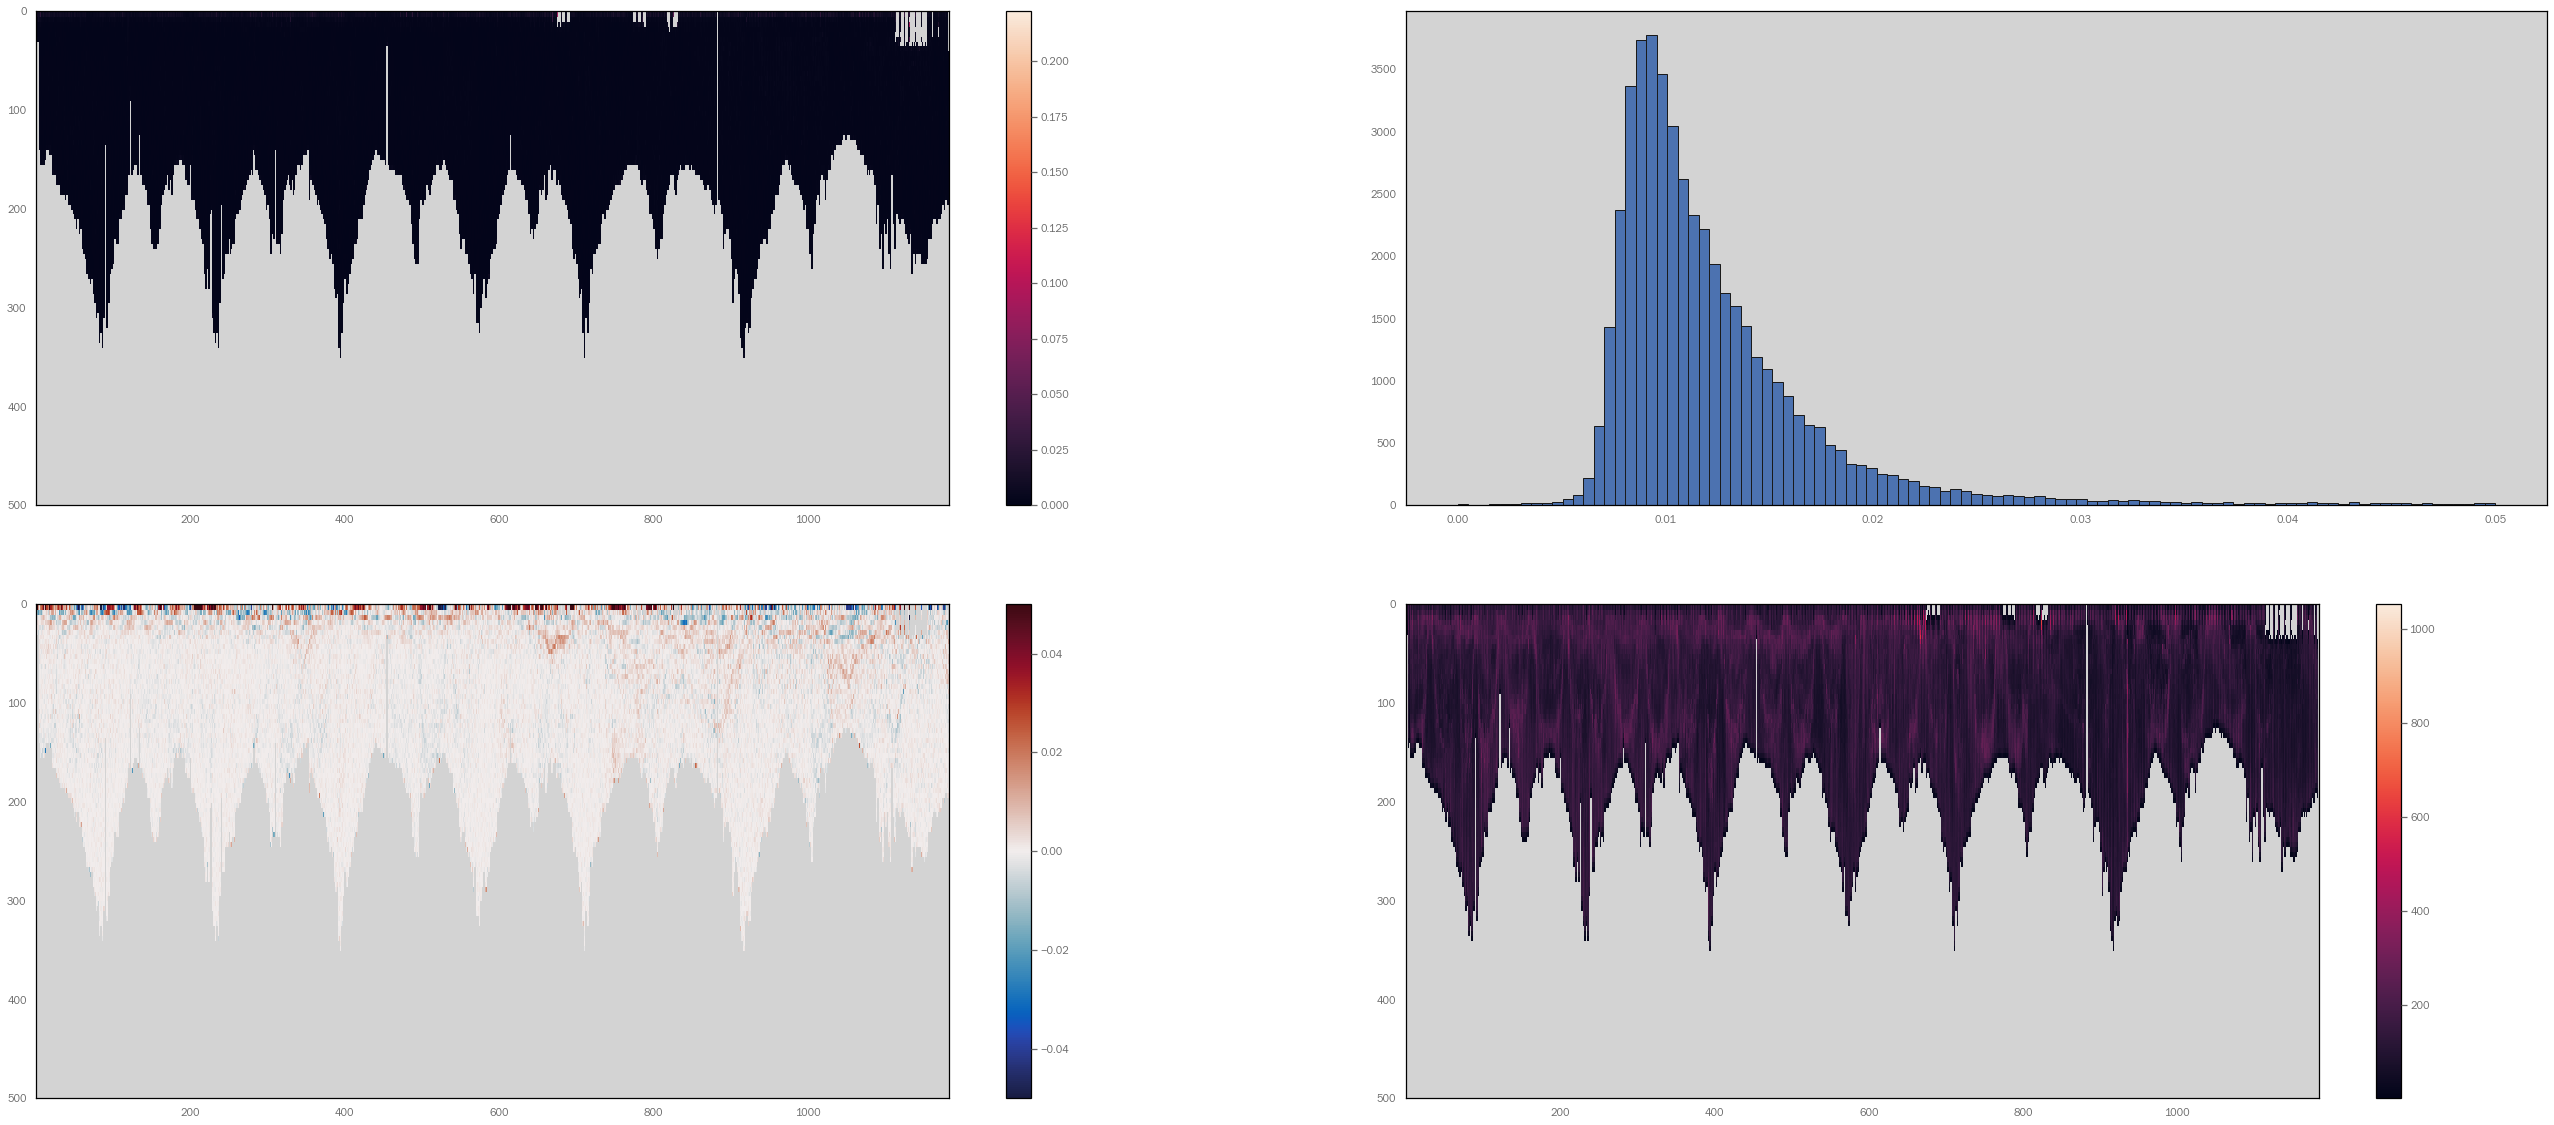

In [37]:
def verify():
    x = np.arange(0,np.shape(ADCP.Sh_E.values)[0],1)

    SHEm,XI,YI = sx.grid2d(
        np.tile(ADCP.profileNum.values, (len(ADCP.gridded_bin), 1)).T[x,:].flatten(),
        ADCP.bin_depth.values[x,:].flatten(), 
        ADCP.Sh_E.values[x,:].flatten(), 
        xi=1, yi=5, fn=np.nanmean)
    SHEs,XI,YI = sx.grid2d(
        np.tile(ADCP.profileNum.values, (len(ADCP.gridded_bin), 1)).T[x,:].flatten(),
        ADCP.bin_depth.values[x,:].flatten(), 
        ADCP.Sh_E.values[x,:].flatten(), 
        xi=1, yi=5, fn=np.nanstd)
    SHEn,XI,YI = sx.grid2d(
        np.tile(ADCP.profileNum.values, (len(ADCP.gridded_bin), 1)).T[x,:].flatten(),
        ADCP.bin_depth.values[x,:].flatten(), 
        ADCP.Sh_E.values[x,:].flatten(), 
        xi=1, yi=5, fn='count')

    plt.figure(figsize=(45,20))

    plt.subplot(221)
    plt.pcolormesh(XI,YI,SHEs/np.sqrt(SHEn))
    plt.colorbar()
    # plt.clim([0,300])
    plt.ylim([0,500])
    plt.gca().invert_yaxis()

    plt.subplot(223)
    plt.pcolormesh(XI,YI,SHEm,cmap=cmo.balance)
    plt.colorbar()
    plt.ylim([0,500])
    plt.clim([-0.05,0.05])
    plt.gca().invert_yaxis()

    plt.subplot(224)
    plt.pcolormesh(XI,YI,SHEn)
    plt.colorbar()
    plt.ylim([0,500])
    # plt.clim([0,0.01])
    plt.gca().invert_yaxis()

    plt.subplot(222)
    _ = plt.hist(SHEs.flatten(), np.linspace(0,0.05,100))
    
verify()

In [38]:
out = {}
y_res = 1
yaxis = np.arange(0,np.nanmax(np.ceil(data.data.LEGATO_PRESSURE.values)),y_res)
xaxis = data.data.date_float.groupby(data.data.profileNum).agg('mean').index
taxis = pd.to_datetime(data.data.date_float.groupby(data.data.profileNum).agg('mean').values)
days = np.unique(data.data.Timestamp.round('D'))

C:\Users\bastien\AppData\Local\Temp\ipykernel_21472\61472414.py:63: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(taxis,yaxis,V,cmap=cmo.balance,shading='auto')
C:\Users\bastien\AppData\Local\Temp\ipykernel_21472\61472414.py:67: UserWarning: No contour levels were found within the data range.
  plt.contour(taxis,yaxis,SA,np.linspace(35.5,38.5,6),colors='k',alpha=0.3)
C:\Users\bastien\AppData\Local\Temp\ipykernel_21472\61472414.py:63: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(taxis,yaxis,V,cmap=cmo.balance,shading='auto')
C:\Users\bastien\AppData\Lo

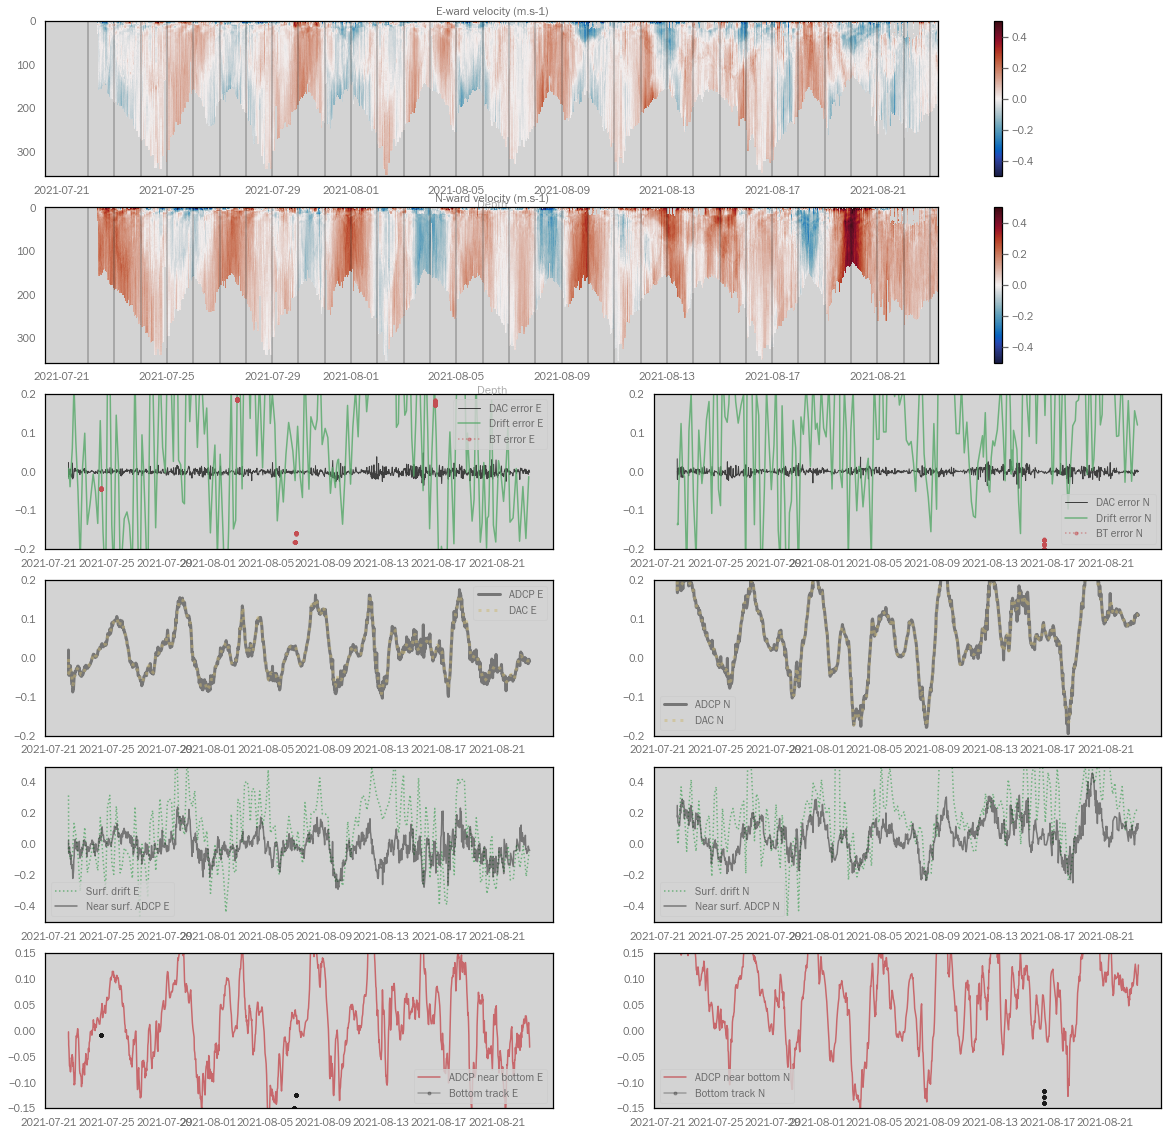

In [39]:
def _verify():
    
    var = ['E','N']
    
    plt.figure(figsize=(20,20))
    
    days = np.unique(data.data.Timestamp.round('D'))
    for pstep in range(len(var)):
        
        letter = var[pstep]
        # Grid shear to average out sensor + zooplankton noise
        Sh,XI,YI = sx.grid2d(
            np.tile(ADCP.profileNum.values, (len(ADCP.gridded_bin), 1)).T.flatten(),
            ADCP.bin_depth.values.flatten(), 
            ADCP['Sh_'+letter].values.flatten(), 
            xi=xaxis, yi=yaxis, fn='mean')

        # Integrate shear vertically
        _bd = ~np.isfinite(Sh) # Preserve what are originally NaN values to recover later as need conversion to 0 for cumsum-
        Sh = np.nan_to_num(Sh) # Replace NaNs with 0 for cumsum
        V = np.cumsum(Sh,axis=0)*y_res # Cumulative sum of shear to recover velocity profile
        V[_bd] = np.NaN # Return NaNs to their rightful place.
        V = V - np.tile(np.nanmean(V, axis=0), (np.shape(V)[0],1)) # Make mean of baroclinic profiles equal to 0

        # Grid DAC
        DAC,XI,YI = sx.grid2d(
            data.data.profileNum.values,
            data.data.LEGATO_PRESSURE.values, 
            data.data['DAC_'+letter].values, 
            xi=xaxis, yi=yaxis, fn='mean')

        # Grid vertical speed
        dPdz,XI,YI = sx.grid2d(
            data.data.profileNum.values,
            data.data.LEGATO_PRESSURE.values, 
            data.data['speed_vert'].values, 
            xi=xaxis, yi=yaxis, fn='mean')

        # Grid salinity
        SA,XI,YI = sx.grid2d(
            data.data.profileNum.values,
            data.data.LEGATO_PRESSURE.values, 
            data.data.sa.values, 
            xi=xaxis, yi=yaxis, fn='median')

        # Seconds spent in each depth bin, to weight referencing
        SpB = y_res / dPdz
        SpB[np.isinf(SpB)] = 0
        strictness = 1
        SpB_std = np.nanstd(SpB.flatten())
        SpB[ np.abs(SpB) > (strictness*SpB_std) ] = strictness*SpB_std

        # Baroclinic velocity, weighted by depth residence time, should be equal to DAC
        # So the reference to add to a baroclinic profile of mean = 0 is the DAC - the weighted baroclinic velocity.    
        Ref = np.nanmean(DAC, axis=0)  -  np.nansum(V*SpB, axis=0)/np.nansum(SpB, axis=0)

        # Now we reference the velocity
        V = V +  np.tile(Ref, (np.shape(V)[0],1))
        out['ADCP_'+letter] = V

        ## PLOT 1
        plt.subplot(6,1, pstep+1)
        plt.pcolormesh(taxis,yaxis,V,cmap=cmo.balance,shading='auto')
        plt.clim(np.array([-1,1])*0.5)
        plt.colorbar()
        [plt.axvline(x, color='k', alpha=0.3) for x in days]
        plt.contour(taxis,yaxis,SA,np.linspace(35.5,38.5,6),colors='k',alpha=0.3)
        plt.gca().invert_yaxis()
        plt.xlabel('Yo number')
        plt.xlabel('Depth')
        plt.title(letter+'-ward velocity (m.s-1)')
        
        ## PLOT 3
        plt.subplot(6,2, pstep+7)
        plt.plot(taxis,np.nanmean(V, axis=0),'-k',alpha=0.5, linewidth=3)
        plt.plot(taxis,np.nanmean(DAC, axis=0),':y',alpha=0.5, linewidth=3)
        plt.legend(('ADCP '+letter,'DAC '+letter))
        plt.ylim([-0.2,0.2])
        
        ## PLOT 4
        plt.subplot(6,2, pstep+9)
        max_depth = 26
        _gd = np.isfinite(dN+dE)
        if pstep==0:
            plt.plot(pd.to_datetime(dT[_gd]),dE[_gd],':g', alpha=0.8)
        else:
            plt.plot(pd.to_datetime(dT[_gd]),dN[_gd],':g', alpha=0.8)   
        V_surf = np.nanmean(V[:max_depth,:], axis=0)
        plt.plot(taxis[np.isfinite(V_surf)],V_surf[np.isfinite(V_surf)],'-k',alpha=0.5)
        plt.legend(('Surf. drift '+letter,'Near surf. ADCP '+letter))
        plt.ylim([-0.5,0.5])
    
        ## PLOT 5
        plt.subplot(6,2, pstep+11)
        
        indices = np.flip(np.cumsum(np.flip(np.full_like(V,1)*np.isfinite(V),axis=0),axis=0),axis=0)
        indices[indices > 10] = np.NaN
        indices[np.isfinite(indices)] = 1
        bottom_V = np.nanmean(V*indices, axis=0)   
        plt.plot(taxis,RunningMean(bottom_V,1),'-r',alpha=0.8)
        
        ind = np.arange(len(ADCP['time'])) #np.isfinite(ADCP['BT_'+letter].values)
        bt_t = ADCP['time'].isel(time=ind).values
        bt = (ADCP[letter]-ADCP['BT_'+letter]).isel(time=ind).mean('gridded_bin').values
        bt_std = (ADCP[letter]-ADCP['BT_'+letter]).isel(time=ind).std('gridded_bin').values
    
        bt_smooth = 30
        plt.plot( bt_t , RunningMean(bt,bt_smooth), '-k', marker='.', alpha=0.3)
        plt.ylim([-0.15,0.15])
        plt.legend(('ADCP near bottom '+letter,'Bottom track '+letter))
        
        
        ## PLOT 2
        plt.subplot(6,2, pstep+5)
        plt.plot(taxis,np.nanmean(V, axis=0) - np.nanmean(DAC, axis=0),'-k',alpha=0.8, linewidth=1)
        
        if pstep==0:
            plt.plot(pd.to_datetime(dT[_gd]),dE[_gd] - interp(taxis[np.isfinite(V_surf)].values.astype('float'),V_surf[np.isfinite(V_surf)],dT[_gd]) ,'-g', alpha=0.8)
        else:
            plt.plot(pd.to_datetime(dT[_gd]),dN[_gd] - interp(taxis[np.isfinite(V_surf)].values.astype('float'),V_surf[np.isfinite(V_surf)],dT[_gd]),'-g', alpha=0.8)   
        
        plt.plot( bt_t , RunningMean(bt,bt_smooth) - interp(taxis.values.astype('float'),RunningMean(bottom_V,1) , bt_t.astype('float')), ':r', marker='.', alpha=0.5)
        
        plt.legend(('DAC error '+letter,'Drift error '+letter,'BT error '+letter))
        plt.ylim([-0.2,0.2])
        
        
    # plt.savefig(filename[:filename.rfind('/')+1]+'currents.png', bbox_inches='tight')
    
_verify()

# VI. Grid and plot data

In [40]:
def _grid_glider_data(data): 
    exclude_from_grid = ['AD2CP_ALT', 'AD2CP_HEADING', 'AD2CP_PITCH', 'AD2CP_PRESSURE',
    'AD2CP_ROLL', 'AROD_FT_DO', 'AROD_FT_TEMP', 'Altitude', 'AngCmd',
    'AngPos', 'BallastCmd', 'BallastPos', 'DeadReckoning', 'Declination',
    'Depth', 'DesiredH','LinCmd', 'LinPos','NAV_DEPTH', 'NAV_LATITUDE', 'NAV_LONGITUDE',
    'NAV_RESOURCE', 'NavState', 'Pa', 'Pitch', 'Roll', 'Heading', 'SecurityLevel', 'Temperature',
    'Timestamp', 'Unnamed: 22', 'Unnamed: 28', 'Voltage', 'missionNum','Lat','Lon']

    variables = data.columns
    variables = [x for x in variables if x not in exclude_from_grid]
    grid = lambda name : sx.grid2d(data.profileNum.values, data.LEGATO_PRESSURE.values, data[name].values, xi=xaxis, yi=yaxis, fn='mean')[0]

    for varname in tqdm(variables):
        try:
            out[varname] = grid(varname)
        except:
            print('Variable "'+varname+'" failed to grid.')

    return out

In [41]:
ADCP_pnum = np.tile(ADCP.profileNum, (len(ADCP.gridded_bin),1)).T
out['Sh_E'] = sx.grid2d(ADCP_pnum.flatten(), ADCP.bin_depth.values.flatten(), ADCP.Sh_E.values.flatten(), xi=xaxis, yi=yaxis, fn='mean')[0]
out['Sh_N'] = sx.grid2d(ADCP_pnum.flatten(), ADCP.bin_depth.values.flatten(), ADCP.Sh_N.values.flatten(), xi=xaxis, yi=yaxis, fn='mean')[0]
out['Sh_U'] = sx.grid2d(ADCP_pnum.flatten(), ADCP.bin_depth.values.flatten(), ADCP.Sh_U.values.flatten(), xi=xaxis, yi=yaxis, fn='mean')[0]
out['Heading'] = sx.grid2d(ADCP.profileNum.values, ADCP.Pressure.values, ADCP['Heading'].values, xi=xaxis, yi=yaxis, fn='mean')[0]
out['Pitch'] = sx.grid2d(ADCP.profileNum.values, ADCP.Pressure.values, ADCP['Pitch'].values, xi=xaxis, yi=yaxis, fn='mean')[0]
out['Roll'] = sx.grid2d(ADCP.profileNum.values, ADCP.Pressure.values, ADCP['Roll'].values, xi=xaxis, yi=yaxis, fn='mean')[0]
out['latitude'] = sx.grid2d(ADCP.profileNum.values, ADCP.Pressure.values, ADCP['Latitude'].values, xi=xaxis, yi=yaxis, fn='mean')[0]
out['longitude'] = sx.grid2d(ADCP.profileNum.values, ADCP.Pressure.values, ADCP['Longitude'].values, xi=xaxis, yi=yaxis, fn='mean')[0]
out['profileNum'] = sx.grid2d(ADCP.profileNum.values, ADCP.Pressure.values, ADCP['profileNum'].values, xi=xaxis, yi=yaxis, fn='mean')[0]
out['Pressure'] = sx.grid2d(ADCP.profileNum.values, ADCP.Pressure.values, ADCP['Pressure'].values, xi=xaxis, yi=yaxis, fn='mean')[0]

out = _grid_glider_data(data.data)

# out['ABS'] = sx.grid2d(ADCP_pnum.flatten(), ADCP.bin_depth.values.flatten(), 
#                           (ADCP.A1.values.flatten()+ADCP.A2.values.flatten()+ADCP.A3.values.flatten()+ADCP.A4.values.flatten())/4,
#                           xi=xaxis, yi=yaxis, fn='mean')[0]


100%|██████████████████████████████████████████| 37/37 [00:18<00:00,  2.01it/s]


D:\miniconda3\envs\py3.10\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


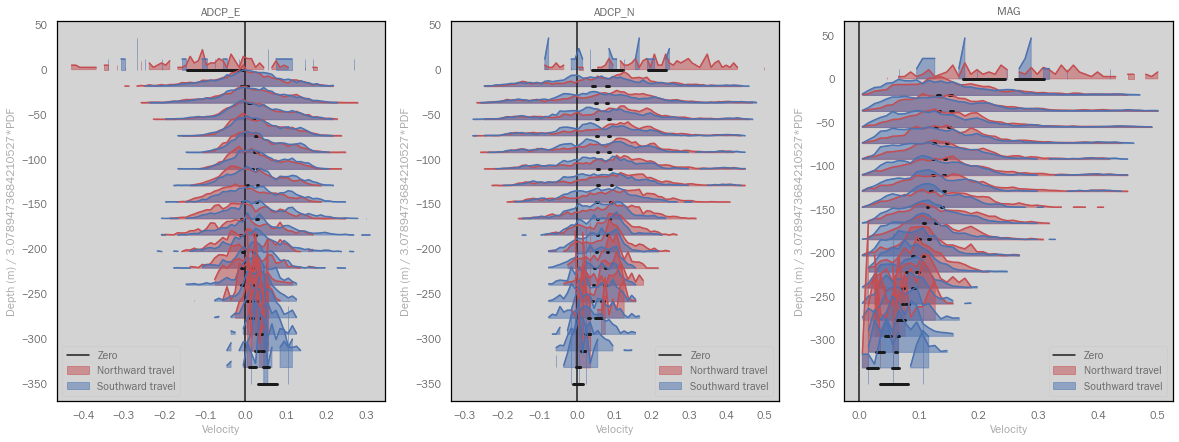

In [42]:
def verify_depth_bias(E='ADCP_E',N='ADCP_N'):
    
    north = np.gradient(out['latitude'],axis=1) > 0
    south = np.gradient(out['latitude'],axis=1) < 0
    
    up = np.remainder(out['profileNum'],2) == 0
    down = np.remainder(out['profileNum'],2) == 1
    
    
    depths = np.linspace(0,np.max(yaxis)-5,20)
    drange = np.mean(np.diff(depths))/2
    bins = np.linspace(-1,1,100) * 0.5
    
    variables = [E,N]
    
    plt.figure(figsize=(20,7))
    
    SF = drange/3
    
    for idx,var in enumerate(variables):
        plt.subplot(1,3,idx+1)
        plt.axvline(0,color='k')

        for idx, d in enumerate(depths):
            depth = (np.abs(out['Pressure'] - d) < drange)
            
            Nvals = out[var][(north & depth)]
            Svals = out[var][(south & depth)]
            N,_ = np.histogram(Nvals,bins=bins,density=True)
            S,_ = np.histogram(Svals,bins=bins,density=True)

            Nm = np.nanmean(Nvals)
            Sm = np.nanmean(Svals)
            Ns = np.nanstd(Nvals)
            Ss = np.nanstd(Svals)
            Nn = np.count_nonzero(np.isfinite(Nvals))
            Sn = np.count_nonzero(np.isfinite(Svals))
            Nse = Ns / np.sqrt(Nn)
            Sse = Ss / np.sqrt(Sn)

            N[N==0] = np.NaN
            S[S==0] = np.NaN

            plt.fill_between(bins[1:],SF*N-float(d),-float(d),color='r',alpha=0.5)
            plt.fill_between(bins[1:],SF*S-float(d),-float(d),color='b',alpha=0.5)
            plt.plot(bins[1:],SF*N-float(d),'-r')
            plt.plot(bins[1:],SF*S-float(d),'-b')
        
            plt.plot([Nm-2*Nse,Nm+2*Nse],np.array([1,1])*-float(d),'-k',linewidth=3,alpha=1)
            plt.plot([Sm-2*Sse,Sm+2*Sse],np.array([1,1])*-float(d),'-k',linewidth=3,alpha=1)
            # plt.plot([Nm,Sm],np.array([1,1])*-float(d),'k',marker='.',linestyle='none')

        plt.ylabel('Depth (m) / '+str(SF)+'*PDF')
        plt.xlabel('Velocity')
        plt.legend(('Zero','Northward travel','Southward travel'))
        plt.title(var)
        
    plt.subplot(133)    
    plt.axvline(0,color='k')

    for idx, d in enumerate(depths):
        depth = (np.abs(out['Pressure'] - d) < drange)

        Nvals = np.sqrt(out['ADCP_E']**2 + out['ADCP_N']**2)[(north & depth)]
        Svals = np.sqrt(out['ADCP_E']**2 + out['ADCP_N']**2)[(south & depth)]
        N,_ = np.histogram(Nvals,bins=bins,density=True)
        S,_ = np.histogram(Svals,bins=bins,density=True)

        Nm = np.nanmean(Nvals)
        Sm = np.nanmean(Svals)
        Ns = np.nanstd(Nvals)
        Ss = np.nanstd(Svals)
        Nn = np.count_nonzero(np.isfinite(Nvals))
        Sn = np.count_nonzero(np.isfinite(Svals))
        Nse = Ns / np.sqrt(Nn)
        Sse = Ss / np.sqrt(Sn)

        N[N==0] = np.NaN
        S[S==0] = np.NaN

        plt.fill_between(bins[1:],SF*N-float(d),-float(d),color='r',alpha=0.5)
        plt.fill_between(bins[1:],SF*S-float(d),-float(d),color='b',alpha=0.5)
        plt.plot(bins[1:],SF*N-float(d),'-r')
        plt.plot(bins[1:],SF*S-float(d),'-b')
        
        plt.plot([Nm-2*Nse,Nm+2*Nse],np.array([1,1])*-float(d),'-k',linewidth=3,alpha=1)
        plt.plot([Sm-2*Sse,Sm+2*Sse],np.array([1,1])*-float(d),'-k',linewidth=3,alpha=1)
        # plt.plot([Nm,Sm],np.array([1,1])*-float(d),'k',marker='.',linestyle='none')

    plt.ylabel('Depth (m) / '+str(SF)+'*PDF')
    plt.xlabel('Velocity')
    plt.legend(('Zero','Northward travel','Southward travel'))
    plt.title('MAG')

    # plt.savefig(filename[:filename.rfind('/')+1]+'ADCP_dsitribution.png', bbox_inches='tight')

    return None

verify_depth_bias()

In [43]:
# # Robert Todd method

# def get_bias(C):
#     bias = yaxis*C/np.max(yaxis) 
#     bias = bias-np.mean(bias)
#     return np.tile(bias,[len(taxis),1]).T

# def M_xyz2enu(heading,pitch,roll):
#     hh = np.pi*(heading-90)/180
#     pp = np.pi*pitch/180
#     rr = np.pi*roll/180

#     _H = np.array([
#         [np.cos(hh),np.sin(hh),0], 
#         [-np.sin(hh),np.cos(hh),0], 
#         [0,0,1]
#     ])
#     _P = np.array([
#         [np.cos(pp), 0, -np.sin(pp)] ,
#         [0, 1, 0] , 
#         [ np.sin(pp), 0, np.cos(pp)]
#     ])
#     _R = np.array([
#         [1, 0, 0] ,
#         [0, np.cos(rr), -np.sin(rr)] , 
#         [0, np.sin(rr), np.cos(rr)]
#     ])

#     _M = _H@_P@_R
#     return _M

# X_bias = get_bias(0.1)
# Y_bias = get_bias(0.5)

# if top_mounted:
#     direction = 1
# else:
#     direction = -1

# # E = ADCP['X'].values.copy()
# # N = ADCP['Y'].values.copy()*direction
# # U = ADCP['Z'].values.copy()*direction

# r,c = np.shape(X_bias)

# X = X_bias.flatten()
# Y = Y_bias.flatten()
# H = out['Heading'].flatten()
# P = out['Pitch'].flatten()
# R = out['Roll'].flatten()

# E_bias = np.full(len(X),np.NaN)
# N_bias = np.full(len(X),np.NaN)
# U_bias = np.full(len(X),np.NaN)

# for i in tqdm(range(len(X))):
#     E_bias[i], N_bias[i], _ = M_xyz2enu(H[i],P[i],R[i]) @ [X[i], Y[i], 0]

# E_bias = np.reshape(E_bias, (r,c))
# N_bias = np.reshape(N_bias, (r,c))

# out['ADCP_E_corr'] = out['ADCP_E'] + E_bias
# out['ADCP_N_corr'] = out['ADCP_N'] + N_bias


# verify_depth_bias(E = 'ADCP_E_corr', N = 'ADCP_N_corr')

 26%|██████████▋                              | 26/100 [00:01<00:04, 16.14it/s]
C:\Users\bastien\AppData\Local\Temp\ipykernel_21472\2231158559.py:33: RuntimeWarning: Degrees of freedom <= 0 for slice.
  plt.plot(np.nanvar(ADCP_E_old, axis=1),yaxis,'-r')
C:\Users\bastien\AppData\Local\Temp\ipykernel_21472\2231158559.py:34: RuntimeWarning: Degrees of freedom <= 0 for slice.
  plt.plot(np.nanvar(out['ADCP_E'], axis=1),yaxis,'-g')
C:\Users\bastien\AppData\Local\Temp\ipykernel_21472\2231158559.py:36: RuntimeWarning: Degrees of freedom <= 0 for slice.
  plt.plot(np.nanvar(ADCP_N_old, axis=1),yaxis,'-r')
C:\Users\bastien\AppData\Local\Temp\ipykernel_21472\2231158559.py:37: RuntimeWarning: Degrees of freedom <= 0 for slice.
  plt.plot(np.nanvar(out['ADCP_N'], axis=1),yaxis,'-g')


Optimization terminated successfully.
         Current function value: 170674.442706
         Iterations: 26
         Function evaluations: 52
(array([0.00127487]), 170674.4427059208, 26, 52, 0)


C:\Users\bastien\AppData\Local\Temp\ipykernel_21472\2231158559.py:39: RuntimeWarning: Degrees of freedom <= 0 for slice.
  plt.plot(np.nanvar(np.sqrt(ADCP_E_old**2 + ADCP_N_old**2), axis=1),yaxis,'-r')
C:\Users\bastien\AppData\Local\Temp\ipykernel_21472\2231158559.py:40: RuntimeWarning: Degrees of freedom <= 0 for slice.
  plt.plot(np.nanvar(np.sqrt(out['ADCP_E']**2 + out['ADCP_N']**2), axis=1),yaxis,'-g')
C:\Users\bastien\AppData\Local\Temp\ipykernel_21472\2231158559.py:48: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(taxis,yaxis,out['ADCP_E'],cmap=cmo.balance,shading='auto')
C:\Users\bastien\AppData\Local\Temp\ipykernel_21472\2231158559.py:52: UserWarning: No contour levels were found within the data range.
  plt.contour(taxis,yaxis,out['sa'],np.linspace(35.5,38.5,6

Text(0.5, 1.0, 'Northward velocity (m.s-1)')

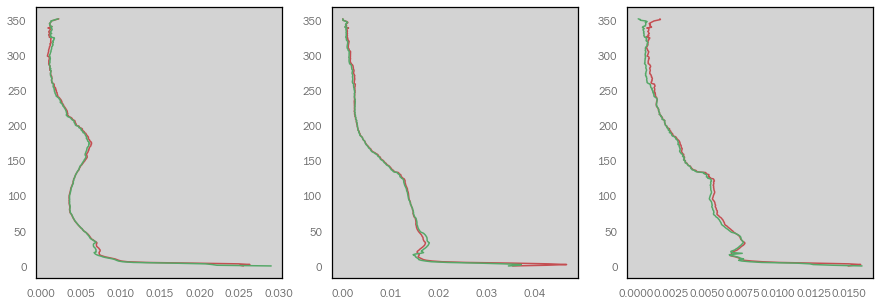

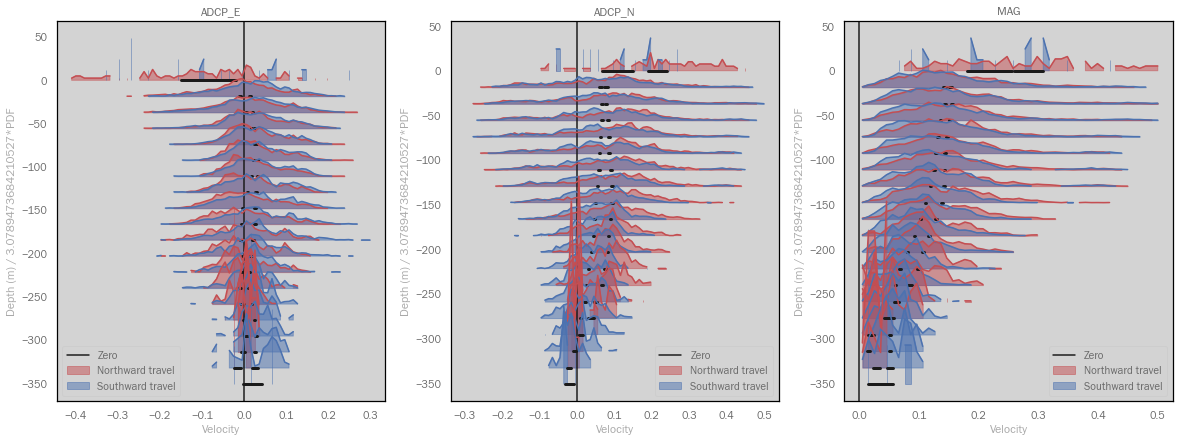

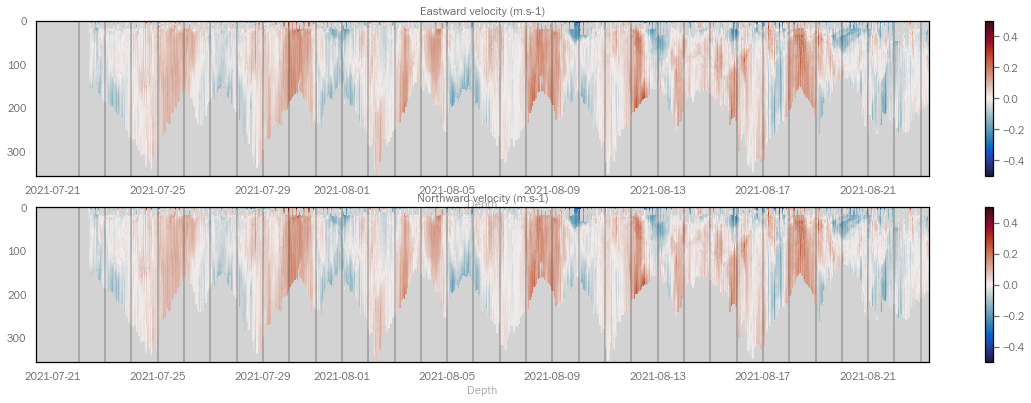

In [44]:
def get_bias(glider_speed, coeff):
    r,c = np.shape(glider_speed)
    bias = np.nancumsum(glider_speed,axis=0)
    bias[~np.isfinite(glider_speed)] = np.NaN
    bias = bias - np.tile(np.nanmean(bias, axis=0),[r,1])
    return bias*coeff

def score(E,N):
    rmsd_h = lambda x: np.sqrt(np.nanmean(x**2, axis=1))
    rmsd = lambda x: np.sqrt(np.nanmean(x**2))
    y_weighting = lambda x: x*0+1
    return rmsd((rmsd_h(E)+rmsd_h(N)) * y_weighting(yaxis))*1e6

def fn(coeff):
    return score(out['ADCP_E'] + get_bias(out['speed_e'], coeff),out['ADCP_N'] + get_bias(out['speed_n'], coeff))

from scipy.optimize import fmin
with tqdm(total=100) as pbar:
    def callbackF(Xi):
        pbar.update(1)
    R = fmin(fn, 1, callback=callbackF, disp=True, full_output=True, maxiter=100, ftol=0.00001)
print(R)
coeff = R[0]

ADCP_E_old = out['ADCP_E'].copy()
ADCP_N_old = out['ADCP_N'].copy()

out['ADCP_E'] = out['ADCP_E'] + get_bias(out['speed_e'], coeff)
out['ADCP_N'] = out['ADCP_N'] + get_bias(out['speed_n'], coeff)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(np.nanvar(ADCP_E_old, axis=1),yaxis,'-r')
plt.plot(np.nanvar(out['ADCP_E'], axis=1),yaxis,'-g')
plt.subplot(132)
plt.plot(np.nanvar(ADCP_N_old, axis=1),yaxis,'-r')
plt.plot(np.nanvar(out['ADCP_N'], axis=1),yaxis,'-g')
plt.subplot(133)
plt.plot(np.nanvar(np.sqrt(ADCP_E_old**2 + ADCP_N_old**2), axis=1),yaxis,'-r')
plt.plot(np.nanvar(np.sqrt(out['ADCP_E']**2 + out['ADCP_N']**2), axis=1),yaxis,'-g')

verify_depth_bias(E = 'ADCP_E', N = 'ADCP_N')


plt.figure(figsize=(20,20))
## PLOT 1
plt.subplot(6,1,1)
plt.pcolormesh(taxis,yaxis,out['ADCP_E'],cmap=cmo.balance,shading='auto')
plt.clim(np.array([-1,1])*0.5)
plt.colorbar()
[plt.axvline(x, color='k', alpha=0.3) for x in days]
plt.contour(taxis,yaxis,out['sa'],np.linspace(35.5,38.5,6),colors='k',alpha=0.3)
plt.gca().invert_yaxis()
plt.xlabel('Yo number')
plt.xlabel('Depth')
plt.title('Eastward velocity (m.s-1)')

plt.subplot(6,1,2)
plt.pcolormesh(taxis,yaxis,out['ADCP_E'],cmap=cmo.balance,shading='auto')
plt.clim(np.array([-1,1])*0.5)
plt.colorbar()
[plt.axvline(x, color='k', alpha=0.3) for x in days]
plt.contour(taxis,yaxis,out['sa'],np.linspace(35.5,38.5,6),colors='k',alpha=0.3)
plt.gca().invert_yaxis()
plt.xlabel('Yo number')
plt.xlabel('Depth')
plt.title('Northward velocity (m.s-1)')


In [45]:
out.keys()

dict_keys(['ADCP_E', 'ADCP_N', 'Sh_E', 'Sh_N', 'Sh_U', 'Heading', 'Pitch', 'Roll', 'latitude', 'longitude', 'profileNum', 'Pressure', 'AD2CP_V1_CN1', 'AD2CP_V2_CN1', 'AD2CP_V3_CN1', 'AD2CP_V4_CN1', 'FLNTU_CHL_COUNT', 'FLNTU_CHL_SCALED', 'FLNTU_NTU_COUNT', 'FLNTU_NTU_SCALED', 'LEGATO_CONDUCTIVITY', 'LEGATO_PRESSURE', 'LEGATO_SALINITY', 'LEGATO_TEMPERATURE', 'Unnamed: 25', 'diveNum', 'depth', 'date_float', 'salinity', 'temperature', 'sa', 'ct', 'sigma0', 'soundspeed', 'o2', 'o2_sat', 'aou', 'alpha', 'speed', 'speed_vert', 'speed_horz', 'w_H2O', 'speed_e', 'speed_n', 'DAC_E', 'DAC_N'])